# IE 6400 - Foundations of Data Analytics Engineering

# Project 3 - Keyword Co-occurance Network - By Aditya Rajendra Shanbhag

## I) Getting all required files from Google Drive Path

In [1]:
from google.colab import drive
drive.mount('/content/drive')

# Set working directory
%cd /content/drive/MyDrive/IE6400_Project_3

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/IE6400_Project_3


## II) Import required libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import itertools
from itertools import combinations
from collections import Counter
import networkx as nx
import community.community_louvain as community_louvain
from collections import defaultdict
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## III) Importing Excel file related to Generative AI research papers from Web of Science (WoS) dataset

i) Web of Science Articles Dataset - Year 2020

In [3]:
wos_2020 = pd.read_excel('WoS_new_dataset_articles_02_April/V3_WoS_2020.xls')
wos_2020.shape

(426, 72)

ii) Web of Science Articles Dataset - Year 2021

In [4]:
wos_2021 = pd.read_excel('WoS_new_dataset_articles_02_April/V3_WoS_2021.xls')
wos_2021.shape

(500, 72)

iii) Web of Science Articles Dataset - Year 2022

In [5]:
wos_2022 = pd.read_excel('WoS_new_dataset_articles_02_April/V3_WoS_2022.xls')
wos_2022.shape

(500, 72)

iv) Web of Science Articles Dataset - Year 2023

In [6]:
wos_2023 = pd.read_excel('WoS_new_dataset_articles_02_April/V3_WoS_2023.xls')
wos_2023.shape

(500, 72)

v) Web of Science Articles Dataset - Year 2024

In [7]:
wos_2024 = pd.read_excel('WoS_new_dataset_articles_02_April/V3_WoS_2024.xls')
wos_2024.shape

(500, 72)

## IV) Create Process Keyword for each year

<b> Tokenization - </b> <br>
Pre-processing the Author Keywords using extract_author_keywords function

In [8]:
# Tokenizing Author Keywords using pre-processing Steps

def extract_author_keywords(wos_df):
    """
    Extract and preprocess the 'Author Keywords' column from a given DataFrame.

    Preprocessing steps:
      i) Create a new dataframe with only the "Author Keywords" column
      ii) Removing Null values from the dataset to reduce noise
      iii) Converting the data type of the column to string
      iv) Converting all the Author Keyword column in lower cases
      v) Removing text inside parentheses along with the parentheses
      vi) Remove Stopwords
      vii) Replace acronyms with full terms
    """

    # i)
    wos_new_df = wos_df[["Author Keywords"]].dropna()

    # ii)
    wos_new_df["Author Keywords"] = wos_new_df["Author Keywords"].astype(str).str.lower()

    # iii)
    wos_new_df['Author Keywords'] = wos_new_df['Author Keywords'].replace(to_replace=r'\(\s*[^)]+\s*\)', value='', regex=True)

    # iv)
    stop_words = set(stopwords.words('english')).union({'method', 'approach', 'study', 'analysis', 'model', 'data'})
    wos_new_df['Author Keywords'] = wos_new_df['Author Keywords'].apply(lambda x: ', '.join([kw.strip() for kw in x.split(',') if kw.strip() not in stop_words]))

    # v)
    keyword_list = [kw.strip() for row in wos_new_df['Author Keywords'] for kw in row.split(';')]
    acronym_dict = {''.join(re.findall(r'\b\w', kw)): kw for kw in keyword_list}
    wos_new_df['Author Keywords'] = wos_new_df['Author Keywords'].apply(lambda text: ', '.join(sorted(set(acronym_dict.get(kw.strip(), kw.strip()) for kw in text.split(';')))))

    # vi)
    wos_new_df['Author Keywords'] = wos_new_df['Author Keywords'].apply(
        lambda phrase: ', '.join(sorted(set(' '.join([w[:-1] if w.endswith('s') and not re.match(r'.*(ss|us|is|os|x|z)$', w) else w for w in word.split()])
            for word in phrase.split(', ')))))

    # vii)
    wos_new_df = wos_new_df.drop_duplicates(subset=['Author Keywords'])

    return wos_new_df

# Function to filter keywords in each row
def filter_keywords(row):
    return ', '.join([kw.strip() for kw in str(row).lower().split(', ') if kw.strip() in valid_keywords])

# Function to extract keyword co-occurrence pairs
def get_keyword_pairs(keywords):
    keyword_list = [kw.strip().lower() for kw in keywords.split(",")]
    return list(combinations(keyword_list, 2))

<b> Author Keywords for the Year 2020 </b> <br>
Creating Dataframe and List of the Author Keywords for the year 2020 , finding the frequency of the keywords and eliminating less frequent keywords to reduce outlier in the data.

In [9]:
auth_keyword_2020_df = extract_author_keywords(wos_2020)

# Find count frequencies and filter for frequency > 5
keyword_freq_df = pd.DataFrame(Counter([keyword.strip() for sublist in
                                        auth_keyword_2020_df['Author Keywords'].dropna().str.lower().str.split(', ')
                                        for keyword in sublist]).items(), columns=["Keyword", "Frequency"])

filtered_keywords_df = keyword_freq_df[keyword_freq_df['Frequency'] > 5]
valid_keywords = set(filtered_keywords_df['Keyword'])

# Dataframe after tokenization
auth_keyword_2020_df['Author Keywords'] = auth_keyword_2020_df['Author Keywords'].apply(filter_keywords)
auth_keyword_2020_df = auth_keyword_2020_df[auth_keyword_2020_df['Author Keywords'].str.strip() != ''].reset_index(drop=True)

# Convert column into a list of lists
auth_keyword_2020_list = auth_keyword_2020_df["Author Keywords"].str.split(', ').tolist()

Displaying auth_keyword_2020_df

In [10]:
auth_keyword_2020_df.head()

Author Keywords
0                            artificial intelligence
1                            artificial intelligence
2                            artificial intelligence
3  artificial intelligence, conditional generativ...
4  artificial intelligence, generative adversaria...

<b> Author Keywords for the Year 2021 </b> <br>
Creating Dataframe and List of the Author Keywords for the year 2021 , finding the frequency of the keywords and eliminating less frequent keywords to reduce outlier in the data.

In [11]:
auth_keyword_2021_df = extract_author_keywords(wos_2021)

# Find count frequencies and filter for frequency > 5
keyword_freq_df = pd.DataFrame(Counter([keyword.strip() for sublist in
                                        auth_keyword_2021_df['Author Keywords'].dropna().str.lower().str.split(', ')
                                        for keyword in sublist]).items(), columns=["Keyword", "Frequency"])

filtered_keywords_df = keyword_freq_df[keyword_freq_df['Frequency'] > 5]
valid_keywords = set(filtered_keywords_df['Keyword'])

# Dataframe after tokenization
auth_keyword_2021_df['Author Keywords'] = auth_keyword_2021_df['Author Keywords'].apply(filter_keywords)
auth_keyword_2021_df = auth_keyword_2021_df[auth_keyword_2021_df['Author Keywords'].str.strip() != ''].reset_index(drop=True)

# Convert column into a list of lists
auth_keyword_2021_list = auth_keyword_2021_df["Author Keywords"].str.split(', ').tolist()

Displaying auth_keyword_2021_df

In [12]:
auth_keyword_2021_df.head()

Author Keywords
0                            artificial intelligence
1                                   machine learning
2  artificial intelligence, generative adversaria...
3                                   active inference
4                                     explainable ai

<b> Author Keywords for the Year 2022 </b> <br>
Creating Dataframe and List of the Author Keywords for the year 2022 , finding the frequency of the keywords and eliminating less frequent keywords to reduce outlier in the data.

In [13]:
auth_keyword_2022_df = extract_author_keywords(wos_2022)

# Find count frequencies and filter for frequency > 5
keyword_freq_df = pd.DataFrame(Counter([keyword.strip() for sublist in
                                        auth_keyword_2022_df['Author Keywords'].dropna().str.lower().str.split(', ')
                                        for keyword in sublist]).items(), columns=["Keyword", "Frequency"])

filtered_keywords_df = keyword_freq_df[keyword_freq_df['Frequency'] > 5]
valid_keywords = set(filtered_keywords_df['Keyword'])

# Dataframe after tokenization
auth_keyword_2022_df['Author Keywords'] = auth_keyword_2022_df['Author Keywords'].apply(filter_keywords)
auth_keyword_2022_df = auth_keyword_2022_df[auth_keyword_2022_df['Author Keywords'].str.strip() != ''].reset_index(drop=True)

# Convert column into a list of lists
auth_keyword_2022_list = auth_keyword_2022_df["Author Keywords"].str.split(', ').tolist()

Displaying auth_keyword_2022_df

In [14]:
auth_keyword_2022_df.head()

Author Keywords
0                              explainable ai
1  artificial intelligence, generative design
2  artificial intelligence, generative design
3                              explainable ai
4   artificial intelligence, machine learning

<b> Author Keywords for the Year 2023 </b> <br>
Creating Dataframe and List of the Author Keywords for the year 2023 , finding the frequency of the keywords and eliminating less frequent keywords to reduce outlier in the data.

In [15]:
auth_keyword_2023_df = extract_author_keywords(wos_2023)

# Find count frequencies and filter for frequency > 5
keyword_freq_df = pd.DataFrame(Counter([keyword.strip() for sublist in
                                        auth_keyword_2023_df['Author Keywords'].dropna().str.lower().str.split(', ')
                                        for keyword in sublist]).items(), columns=["Keyword", "Frequency"])

filtered_keywords_df = keyword_freq_df[keyword_freq_df['Frequency'] > 5]
valid_keywords = set(filtered_keywords_df['Keyword'])

# Dataframe after tokenization
auth_keyword_2023_df['Author Keywords'] = auth_keyword_2023_df['Author Keywords'].apply(filter_keywords)
auth_keyword_2023_df = auth_keyword_2023_df[auth_keyword_2023_df['Author Keywords'].str.strip() != ''].reset_index(drop=True)

# Convert column into a list of lists
auth_keyword_2023_list = auth_keyword_2023_df["Author Keywords"].str.split(', ').tolist()

Displaying auth_keyword_2023_df

In [16]:
auth_keyword_2023_df.head()

Author Keywords
0  artificial intelligence, generative ai, human-...
1                           education, generative ai
2      explainable ai, generative ai, responsible ai
3  generative ai, generative model, large languag...
4                          creativity, generative ai

<b> Author Keywords for the Year 2024 </b> <br>
Creating Dataframe and List of the Author Keywords for the year 2024 , finding the frequency of the keywords and eliminating less frequent keywords to reduce outlier in the data.

In [17]:
auth_keyword_2024_df = extract_author_keywords(wos_2024)

# Find count frequencies and filter for frequency > 5
keyword_freq_df = pd.DataFrame(Counter([keyword.strip() for sublist in
                                        auth_keyword_2024_df['Author Keywords'].dropna().str.lower().str.split(', ')
                                        for keyword in sublist]).items(), columns=["Keyword", "Frequency"])

filtered_keywords_df = keyword_freq_df[keyword_freq_df['Frequency'] > 5]
valid_keywords = set(filtered_keywords_df['Keyword'])

# Dataframe after tokenization
auth_keyword_2024_df['Author Keywords'] = auth_keyword_2024_df['Author Keywords'].apply(filter_keywords)
auth_keyword_2024_df = auth_keyword_2024_df[auth_keyword_2024_df['Author Keywords'].str.strip() != ''].reset_index(drop=True)

# Convert column into a list of lists
auth_keyword_2024_list = auth_keyword_2024_df["Author Keywords"].str.split(', ').tolist()

Displaying auth_keyword_2024_df

In [18]:
auth_keyword_2024_df.head()

Author Keywords
0                    foundation model, generative ai
1  foundation model, generative ai, large languag...
2  ai literacy, artificial intelligence, generati...
3  generative adversarial network, generative ai,...
4                                      generative ai

## V) KEYWORD CO-OCCURANCE NETWORK

Functions for reusability of code for Keyword Co-occurance Network

In [19]:
# Function to extract keyword co-occurrence pairs
def get_keyword_pairs(keywords):
    keyword_list = [kw.strip().lower() for kw in keywords.split(",")]
    return list(combinations(keyword_list, 2))

### <b> 2020 </b>

For Year 2020 - We are creating Weighted Keyword Co-occurrence Network to check how frequently pairs of keywords co-occur and to understand the strength of their connections.

We initially extract keyword co-occurrence pairs along with their weights before we create the visualization of the network. We are clustering using Louvain method for community detection algorithm to create clusters based on the keywords and using NetworkX package to visualize the network.

a) Extract keyword co-occurrence pairs before creating Keyword Co-occurrence Network

In [20]:
auth_keyword_2020_df['Author Keywords']= auth_keyword_2020_df["Author Keywords"].apply(get_keyword_pairs)
all_pairs = [pair for sublist in auth_keyword_2020_df['Author Keywords'] for pair in sublist]
pair_counts_2020 = Counter(all_pairs)

b) Weighted Keyword Co-Occurrence Network for the year 2020

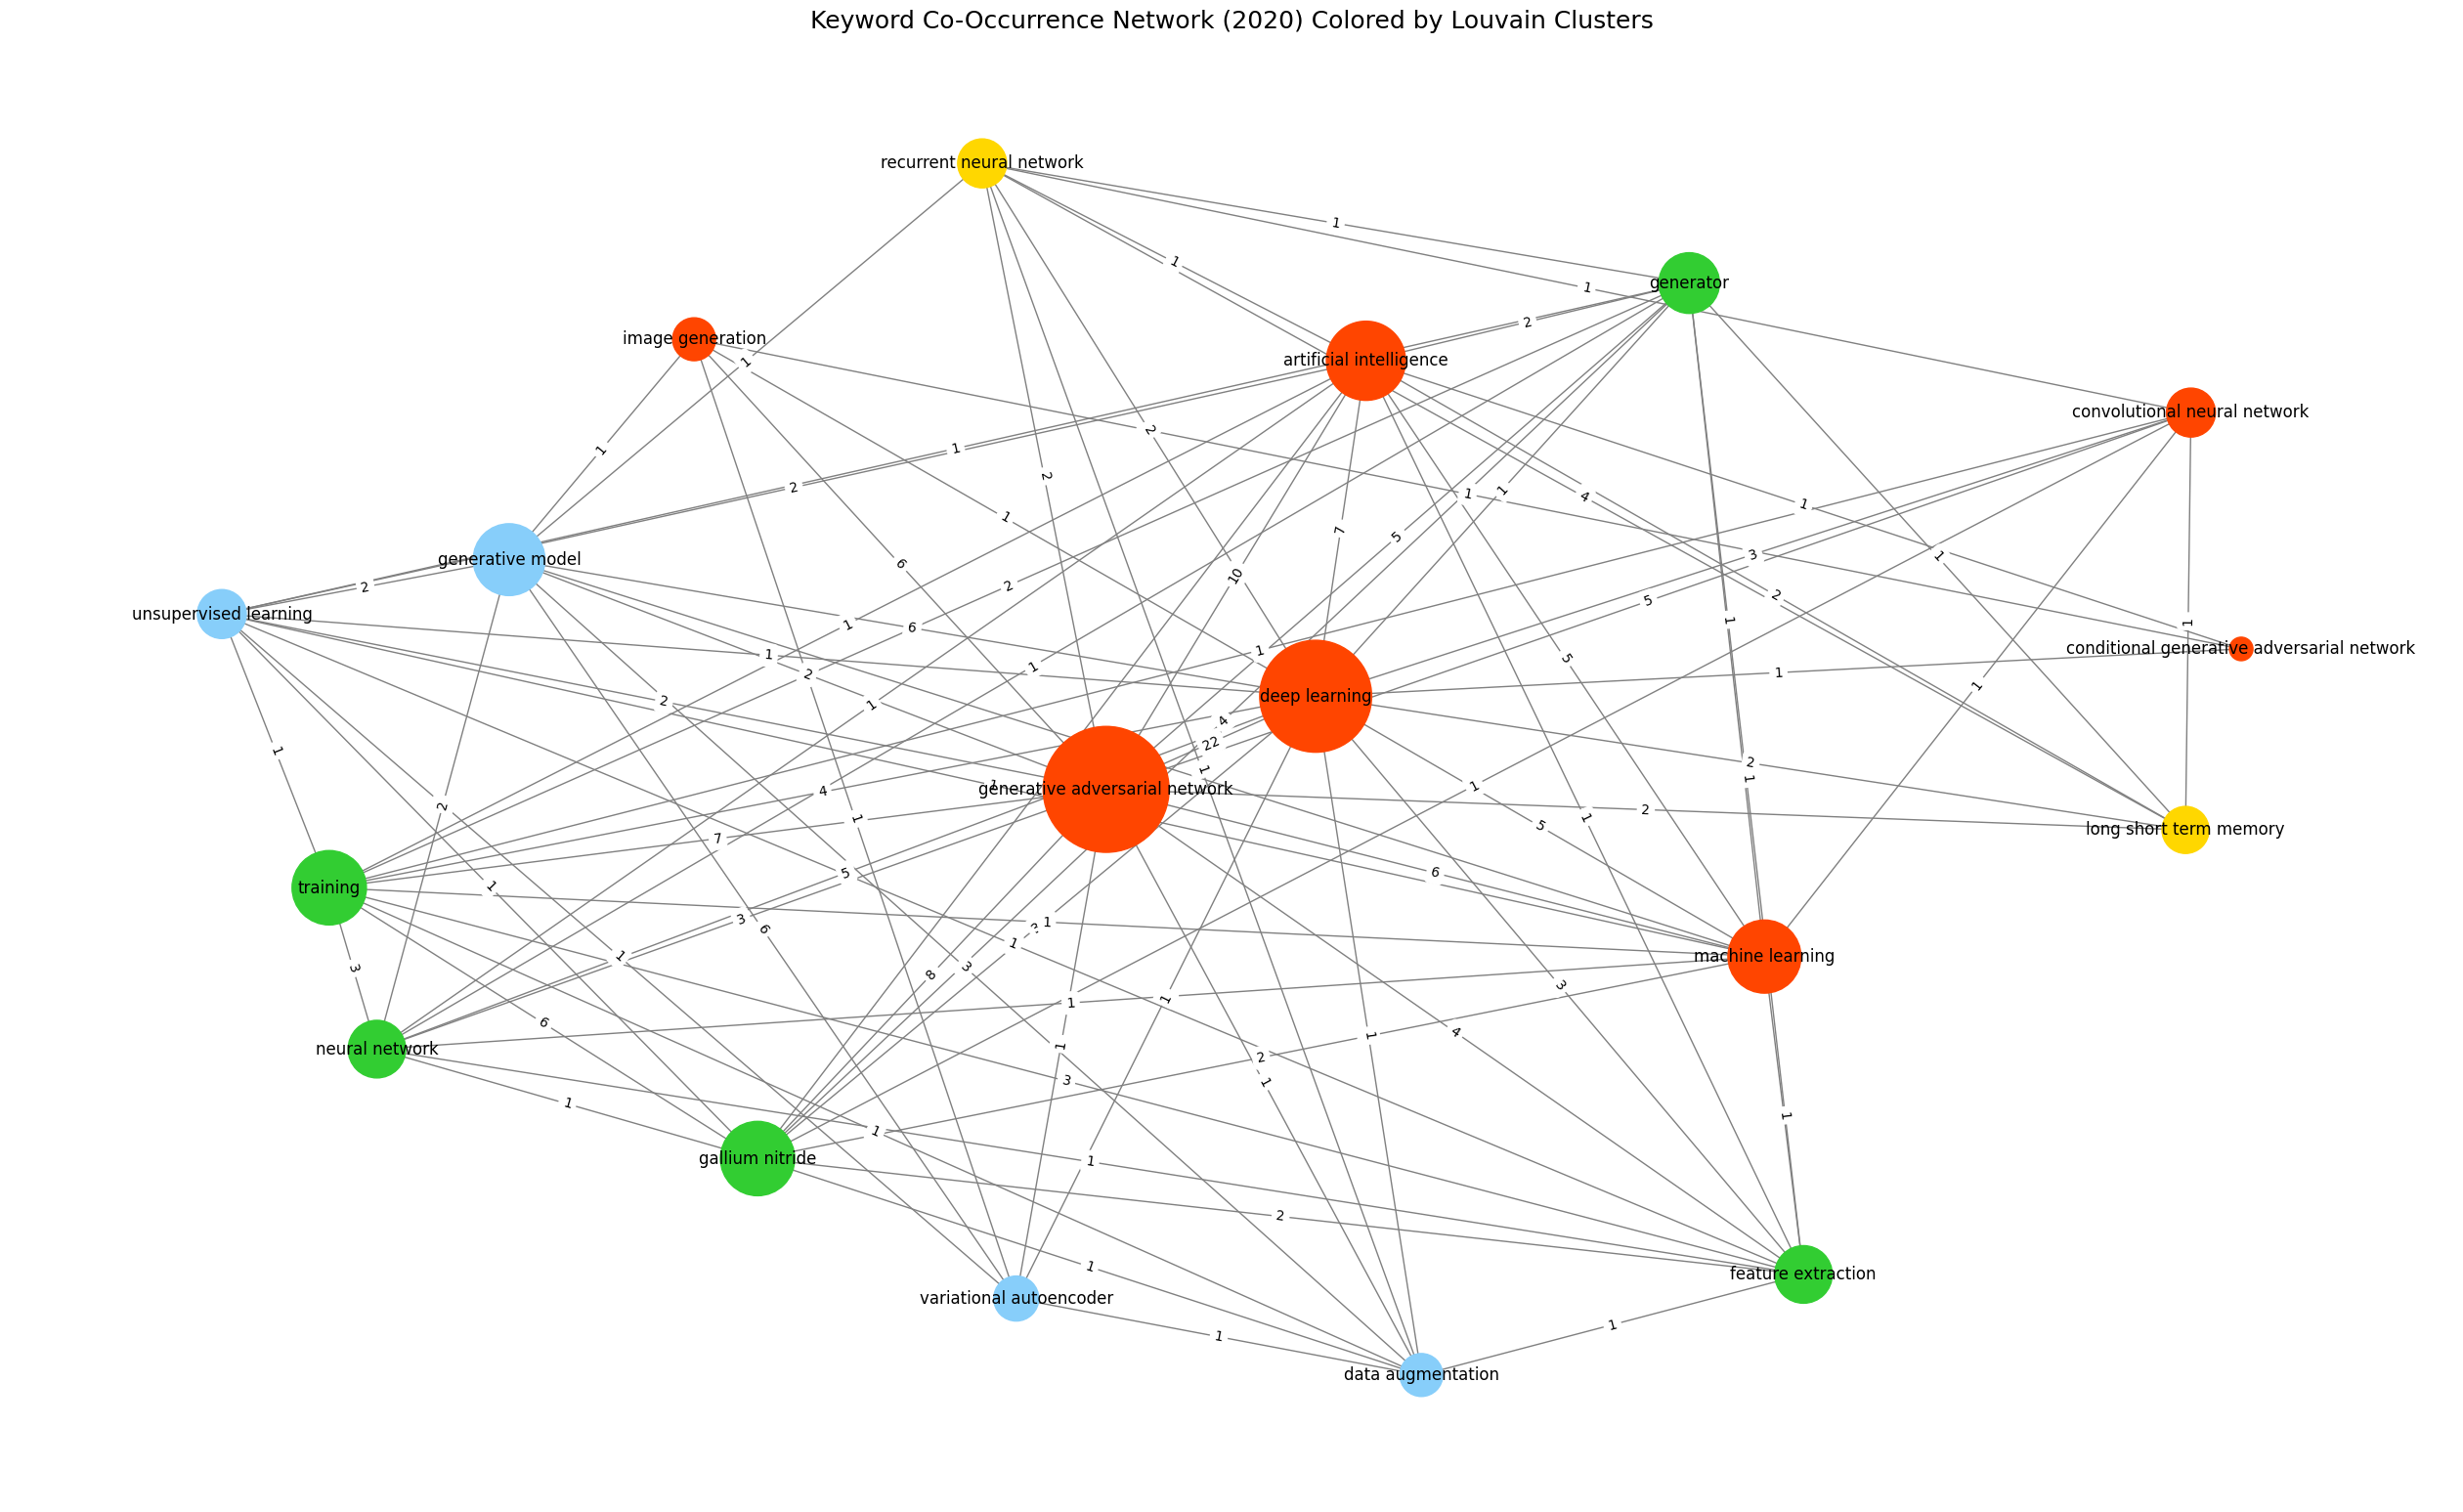

In [21]:
# Create the graph and using Louvain clustering
G_2020 = nx.Graph()
for pair, weight in pair_counts_2020.items():
    G_2020.add_edge(pair[0], pair[1], weight=weight)

pos = nx.spring_layout(G_2020, seed=42, k=4)
partition = community_louvain.best_partition(G_2020)

node_sizes = [100 * G_2020.degree(n, weight='weight') for n in G_2020.nodes()]

custom_colors = ['gold', 'limegreen', 'orangered', 'lightskyblue']
unique_clusters = sorted(set(partition.values()))
cluster_color_map = {cid: custom_colors[i % len(custom_colors)] for i, cid in enumerate(unique_clusters)}
node_colors = [cluster_color_map[partition[node]] for node in G_2020.nodes()]

# Draw network
plt.figure(figsize=(25, 15))
nx.draw(G_2020, pos, with_labels=True, node_size=node_sizes, node_color=node_colors, font_size=12, edge_color="gray")
edge_labels = {(u, v): d.get("weight", 1) for u, v, d in G_2020.edges(data=True)}
nx.draw_networkx_edge_labels(G_2020, pos, edge_labels=edge_labels, font_size=10)

plt.title("Keyword Co-Occurrence Network (2020) Colored by Louvain Clusters", fontsize=18)
plt.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05)
plt.show()


### <b> Analysis - Year 2020 </b>

#### i) Identifying clusters to examine the various research themes or subfields within generative AI, by analyzing which keywords belong to each cluster based on their similarity.

In [22]:
# Create parition and clusters and then group nodes by their cluster ID

partition = community_louvain.best_partition(G_2020)
clusters = defaultdict(list)

for node, cluster_id in partition.items():
    clusters[cluster_id].append(node)

for cluster_id, keywords in clusters.items():
    print(f"Cluster {cluster_id} keywords:")
    print(", ".join(keywords))


Cluster 2 keywords:
artificial intelligence, conditional generative adversarial network, generative adversarial network, deep learning, machine learning, image generation, convolutional neural network
Cluster 0 keywords:
unsupervised learning, generative model, variational autoencoder, data augmentation
Cluster 1 keywords:
neural network, feature extraction, gallium nitride, generator, training
Cluster 3 keywords:
long short term memory, recurrent neural network


<b> Analysis </b> - The Keywords are being clustered into 3 clusters - 0, 1 and 2 based on their similarity within the broader context of generative AI research.
<br><br>
<u> Cluster 0: </u>  Based on the keywords, the group is mainly related to unsupervised learning and related topics <br>
<u> Cluster 1: </u>  Based on the keywords, the group is mainly related to Artificial Intelligence and related topics <br>
<u> Cluster 2: </u>  Based on the keywords, the group is mainly related to neural network and feature extraction <br>
<u> Cluster 3: </u>  Based on the keywords, the group is mainly related to Neural Networks

#### ii) Degree Centrality

In [23]:
# Top 5 Degree Centrality

degree = nx.degree_centrality(G_2020)
top_5_degree = sorted(degree.items(), key=lambda x: x[1], reverse=True)[:5]
print(top_5_degree)

[('deep learning', 1.0), ('generative adversarial network', 0.9411764705882353), ('artificial intelligence', 0.7058823529411764), ('machine learning', 0.6470588235294118), ('gallium nitride', 0.6470588235294118)]


<b>Analysis</b>
<br>
a) ‘deep learning’ holds the highest centrality score (1.0), indicating its position as the central hub within the generative AI research.
<br>
b) Closely related terms like ‘artificial intelligence’, ‘generative adversarial network’, and ‘machine Learning’ also show high centrality, reflecting their role as foundational keywords that frequently co-occur with a wide range of concepts across the generative AI domain.

#### iii) Top 5 Strongest Connections by Weight

In [24]:
# Get Top 5 Keyword pair with highest co-occurrence weights
weighted_edges = [(u, v, d['weight']) for u, v, d in G_2020.edges(data=True)]
top_edges = sorted(weighted_edges, key=lambda x: x[2], reverse=True)[:5]
print("Top 5 Strongest Keyword Connections:")
for u, v, weight in top_edges:
    print(f"{u} ↔ {v} : {weight}")


Top 5 Strongest Keyword Connections:
generative adversarial network ↔ deep learning : 22
artificial intelligence ↔ generative adversarial network : 10
generative adversarial network ↔ gallium nitride : 8
artificial intelligence ↔ deep learning : 7
generative adversarial network ↔ training : 7


<b>Analysis</b>
<br>
a) The strongest link with ‘deep learning’ with a weight of 22 is generative adversal networks.

#### iv) Identification of Key Research Themes - Year 2020

<b> Zipfs law </b>

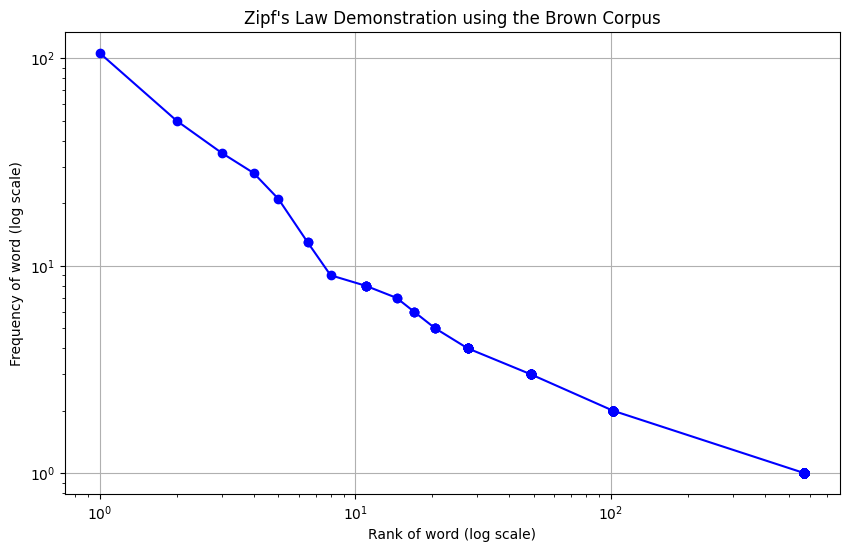

In [25]:
ak_2020_df = extract_author_keywords(wos_2020)
ak_2020_freq_df = pd.DataFrame(Counter([keyword.strip() for sublist in ak_2020_df['Author Keywords'].dropna().str.lower().str.split(', ') for keyword in sublist]).items(), columns=["Keyword", "Frequency"])
ak_2020_freq_df = ak_2020_freq_df.sort_values(by="Frequency", ascending=False)
ak_2020_freq_df['Rank'] = ak_2020_freq_df['Frequency'].rank(ascending=False)

# Plotting Zipfs law

plt.figure(figsize=(10, 6))
plt.loglog(ak_2020_freq_df['Rank'], ak_2020_freq_df['Frequency'], marker='o', linestyle='-', color='b')
plt.title('Zipf\'s Law Demonstration using the Brown Corpus')
plt.xlabel('Rank of word (log scale)')
plt.ylabel('Frequency of word (log scale)')
plt.grid(True)
plt.show()


In [26]:
"""
Zipf Law's Analysis

f(r) = C / r^s

where
f(r) = frequency of the word at rank
r = rank of the word (1 for most frequent, 2 for second most frequent, etc.)
C = normalization constant (depends on the dataset)
s = exponent (usually close to 1 for natural languages)

Results:
Positive deviation → keyword is more frequent than Zipf’s Law expected values → possible emerging topic.
Negative deviation → less frequent than expected.

"""
top_freq = ak_2020_freq_df["Frequency"].iloc[0]
ak_2020_freq_df["Expected_Frequency"] = top_freq / ak_2020_freq_df["Rank"]
ak_2020_freq_df["Deviation"] = ak_2020_freq_df["Frequency"] - ak_2020_freq_df["Expected_Frequency"]
df_sorted_by_deviation = ak_2020_freq_df.sort_values(by="Deviation", ascending=False)

df_sorted_by_deviation

Keyword  Frequency   Rank  \
59                             generative model         28    4.0   
66                                    detection          2  102.0   
350                       visual reconstruction          2  102.0   
290                           few-shot learning          2  102.0   
261                                 digital art          2  102.0   
..                                          ...        ...    ...   
15   conditional generative adversarial network          8   11.0   
52                                deep learning         50    2.0   
61                               neural network         13    6.5   
95                                     training         13    6.5   
90                              gallium nitride          9    8.0   

     Expected_Frequency  Deviation  
59            26.500000   1.500000  
66             1.039216   0.960784  
350            1.039216   0.960784  
290            1.039216   0.960784  
261            1.039216   0.960784  
..                  ...        ...  
15             9.636364  -1.636364  
52            53.000000  -3.000000  
61            16.307692  -3.307692  
95            16.307692  -3.307692  
90            13.250000  -4.250000  

[1004 rows x 5 columns]

<b>Analysis:</b> <br>
Based on the above analysis, we observe that 'generative model' with a frequency of 28 has a deviation of 1.5 and keywords with a frequency of 2 have a deviation of around 0.96, suggests that these keywords may be emerging topics for future research.


<b> Avg Weight vs End Point Degree </b>

In [27]:
# Weight of Keyword pairs

G = nx.Graph()

for keyword_list in auth_keyword_2020_list:
    for kw1, kw2 in itertools.combinations(set(keyword_list), 2):
        if G.has_edge(kw1, kw2):
            G[kw1][kw2]['weight'] += 1
        else:
            G.add_edge(kw1, kw2, weight=1)

edges_data = [(u, v, d['weight']) for u, v, d in G.edges(data=True)]
edges_df = pd.DataFrame(edges_data, columns=['Source', 'Target', 'Weight'])
edges_df_sorted = edges_df.sort_values(by='Weight', ascending=False)

edges_df_sorted


Source                          Target  Weight
21  generative adversarial network                   deep learning      22
3          artificial intelligence  generative adversarial network      10
18  generative adversarial network                 gallium nitride       8
20  generative adversarial network                        training       7
9          artificial intelligence                   deep learning       7
..                             ...                             ...     ...
78              feature extraction               data augmentation       1
80                        training    convolutional neural network       1
81               data augmentation        recurrent neural network       1
83          long short term memory    convolutional neural network       1
84        recurrent neural network    convolutional neural network       1

[85 rows x 3 columns]

In [28]:
# Calculate degree and strength for each node
node_stats = []

for node in G.nodes():
    degree = G.degree(node)
    strength = G.degree(node, weight='weight')
    node_stats.append({"Node": node, "Degree": degree, "Strength": strength})

node_stats_df = pd.DataFrame(node_stats)
node_stats_df_sorted = node_stats_df.sort_values(by="Strength", ascending=False)
node_stats_df_sorted.head(10)


Node  Degree  Strength
2   generative adversarial network      16        86
7                    deep learning      17        68
1          artificial intelligence      12        34
13                        training      11        30
11                 gallium nitride      11        30
6                 machine learning      11        29
4                 generative model       9        28
10                       generator      11        20
12              feature extraction      10        18
5                   neural network       9        18

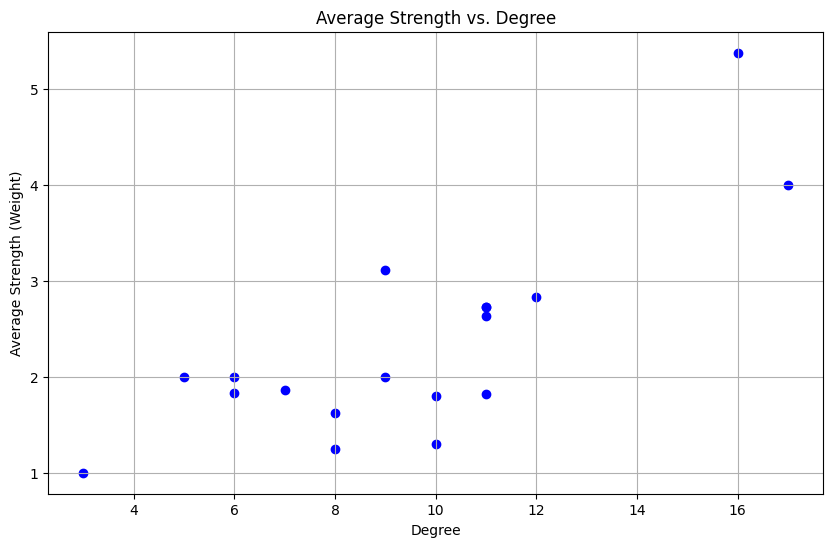

In [29]:
# Calculate average strength for each node
average_strength = {node: 0 for node in G.nodes()}
for node in G.nodes():
    total_weight = sum([attr['weight'] for _, _, attr in G.edges(node, data=True)])
    average_strength[node] = total_weight / G.degree(node)

# Extract degree and average strength for each node
degrees = [G.degree(node) for node in G.nodes()]
average_strengths = [average_strength[node] for node in G.nodes()]

plt.figure(figsize=(10, 6))
plt.scatter(degrees, average_strengths, color='blue')
plt.title("Average Strength vs. Degree")
plt.xlabel("Degree")
plt.ylabel("Average Strength (Weight)")
plt.grid(True)
plt.show()

<b> Analysis </b> <br>

a) 'generative adversarial network' is high degree and high average strength indicating that they are high impact keywords and are likely to be trending topics that are used for future research terms.
<br>
b) 'deep learning' is having high degree and moderate average strength indicating that occurs many times and connections are relatively weak.

<b> Final Analysis </b>
<br>
Based on the analysis above for the year 2020, we can see that the focus areas of current research is revolving around these topics - <b> deep learning,
generative adversarial network, artificial intelligence and training </b>. It is likely that future research will continue to evolve around these core areas indicating development in these domains.

### <b> 2021 </b>

For Year 2021 - We are creating Weighted Keyword Co-occurrence Network to check how frequently pairs of keywords co-occur and to understand the strength of their connections.

We initially extract keyword co-occurrence pairs along with their weights before we create the visualization of the network. We are clustering using Louvain method for community detection algorithm to create clusters based on the keywords and using NetworkX package to visualize the network.

a) Extract keyword co-occurrence pairs before creating Keyword Co-occurrence Network

In [30]:
auth_keyword_2021_df['Author Keywords']= auth_keyword_2021_df["Author Keywords"].apply(get_keyword_pairs)
all_pairs = [pair for sublist in auth_keyword_2021_df['Author Keywords'] for pair in sublist]
pair_counts_2021 = Counter(all_pairs)

b) Weighted Keyword Co-Occurrence Network for the year 2021

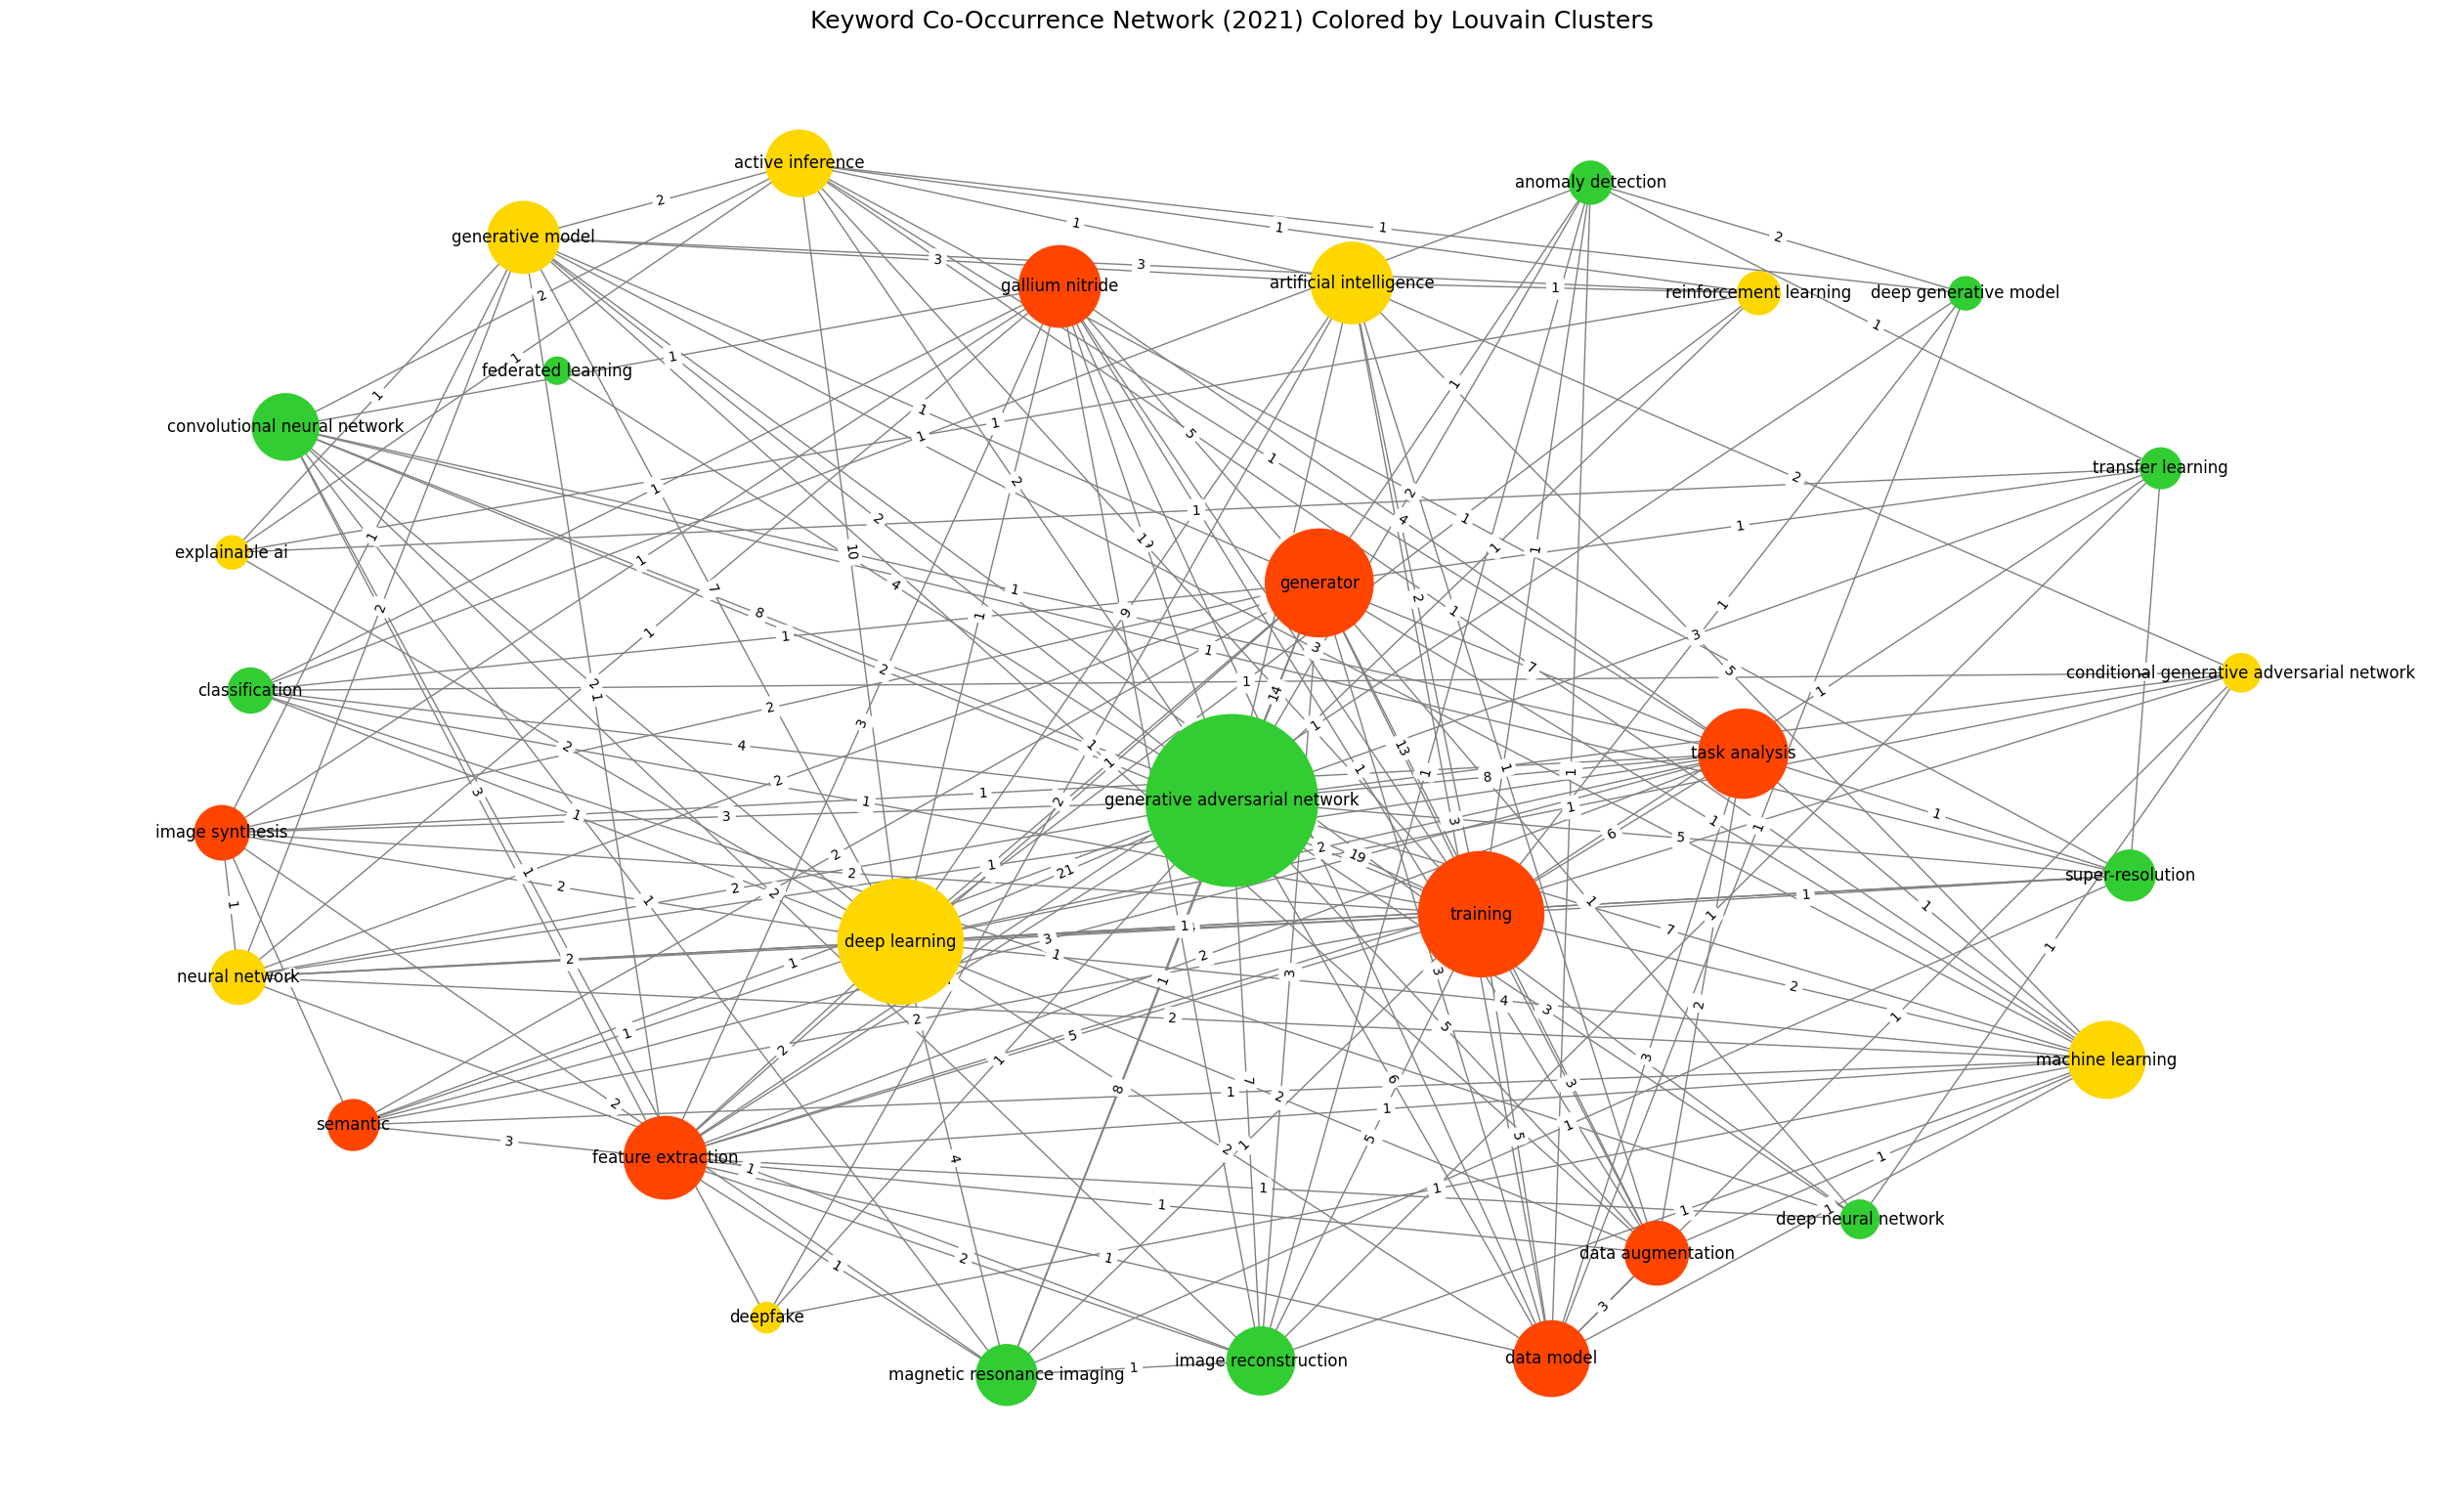

In [70]:
# Create the graph and using Louvain clustering
G_2021 = nx.Graph()
for pair, weight in pair_counts_2021.items():
    G_2021.add_edge(pair[0], pair[1], weight=weight)

pos = nx.spring_layout(G_2021, seed=42, k=4)
partition = community_louvain.best_partition(G_2021)

node_sizes = [100 * G_2021.degree(n, weight='weight') for n in G_2021.nodes()]

custom_colors = ['gold', 'limegreen', 'orangered', 'lightskyblue']
unique_clusters = sorted(set(partition.values()))
cluster_color_map = {cid: custom_colors[i % len(custom_colors)] for i, cid in enumerate(unique_clusters)}
node_colors = [cluster_color_map[partition[node]] for node in G_2021.nodes()]

# Draw network
plt.figure(figsize=(25, 15))
nx.draw(G_2021, pos, with_labels=True, node_size=node_sizes, node_color=node_colors, font_size=12, edge_color="gray")
edge_labels = {(u, v): d.get("weight", 1) for u, v, d in G_2021.edges(data=True)}
nx.draw_networkx_edge_labels(G_2021, pos, edge_labels=edge_labels, font_size=10)

plt.title("Keyword Co-Occurrence Network (2021) Colored by Louvain Clusters", fontsize=18)
plt.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05)
plt.show()


### <b> Analysis - Year 2021 </b>

#### i) Identifying clusters to examine the various research themes or subfields within generative AI, by analyzing which keywords belong to each cluster based on their similarity.

In [71]:
# Create parition and clusters and then group nodes by their cluster ID

partition = community_louvain.best_partition(G_2021)
clusters = defaultdict(list)

for node, cluster_id in partition.items():
    clusters[cluster_id].append(node)

for cluster_id, keywords in clusters.items():
    print(f"Cluster {cluster_id} keywords:")
    print(", ".join(keywords))


Cluster 0 keywords:
artificial intelligence, deep learning, explainable ai, reinforcement learning, generative model, machine learning, deepfake, active inference, conditional generative adversarial network, neural network
Cluster 1 keywords:
generative adversarial network, federated learning, deep neural network, classification, transfer learning, magnetic resonance imaging, super-resolution, convolutional neural network, image reconstruction, deep generative model, anomaly detection
Cluster 2 keywords:
data augmentation, feature extraction, generator, data model, training, image synthesis, gallium nitride, task analysis, semantic


<b> Analysis </b> - The Keywords are being clustered into 3 clusters - 0, 1 and 2 based on their similarity within the broader context of generative AI research.
<br><br>
<u> Cluster 0: </u>  Based on the keywords, the group is mainly related to artificial intelligence and deep learning <br>
<u> Cluster 1: </u>  Based on the keywords, the group is mainly related to Neural network terms <br>
<u> Cluster 2: </u>  Based on the keywords, the group is mainly related to data augmentation and feature extraction

#### ii) Degree Centrality

In [33]:
# Top 5 Degree Centrality

degree = nx.degree_centrality(G_2021)
top_5_degree = sorted(degree.items(), key=lambda x: x[1], reverse=True)[:5]
print(top_5_degree)

[('generative adversarial network', 0.9310344827586207), ('deep learning', 0.7586206896551724), ('training', 0.7586206896551724), ('generator', 0.6551724137931034), ('feature extraction', 0.5862068965517241)]


<b>Analysis</b>
<br>
a) ‘generative adversarial network’ holds the highest centrality score (0.93), indicating its position as the central hub within the generative AI research.
<br>
b) Closely related terms like ‘Deep Learning’ and ‘training’ also show high centrality, reflecting their role as foundational keywords that frequently co-occur with a wide range of concepts across the generative AI domain.

#### iii) Top 5 Strongest Connections by Weight

In [34]:
# Get Top 5 Keyword pair with highest co-occurrence weights
weighted_edges = [(u, v, d['weight']) for u, v, d in G_2021.edges(data=True)]
top_edges = sorted(weighted_edges, key=lambda x: x[2], reverse=True)[:5]
print("Top 5 Strongest Keyword Connections:")
for u, v, weight in top_edges:
    print(f"{u} ↔ {v} : {weight}")


Top 5 Strongest Keyword Connections:
generative adversarial network ↔ deep learning : 21
generative adversarial network ↔ training : 19
generative adversarial network ↔ generator : 14
generator ↔ training : 13
deep learning ↔ active inference : 10


<b>Analysis</b>
<br>
a) The strongest links is ‘generative adversarial network’ and ‘deep learning’ with a weight of 21.

#### iv) Identification of Key Research Themes - Year 2021

<b> Zipfs law </b>

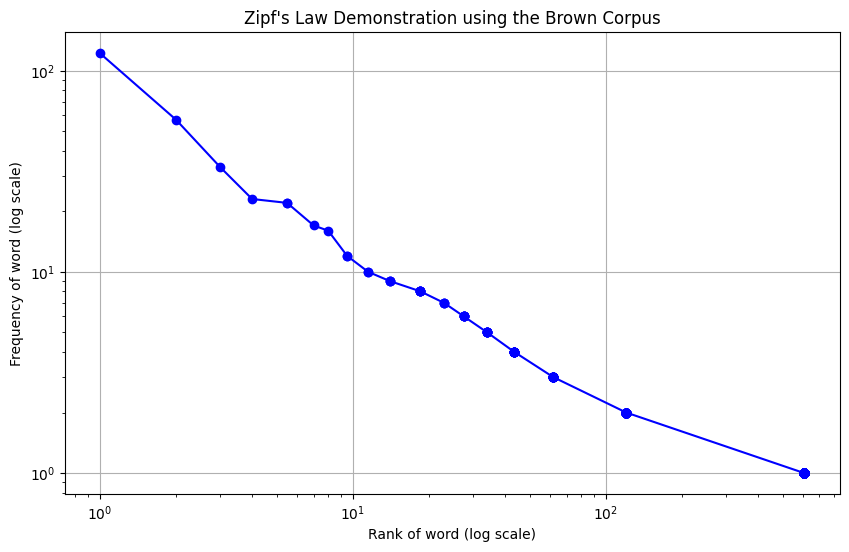

In [35]:
ak_2021_df = extract_author_keywords(wos_2021)
ak_2021_freq_df = pd.DataFrame(Counter([keyword.strip() for sublist in ak_2021_df['Author Keywords'].dropna().str.lower().str.split(', ') for keyword in sublist]).items(), columns=["Keyword", "Frequency"])
ak_2021_freq_df = ak_2021_freq_df.sort_values(by="Frequency", ascending=False)
ak_2021_freq_df['Rank'] = ak_2021_freq_df['Frequency'].rank(ascending=False)

# Plotting Zipfs law

plt.figure(figsize=(10, 6))
plt.loglog(ak_2021_freq_df['Rank'], ak_2021_freq_df['Frequency'], marker='o', linestyle='-', color='b')
plt.title('Zipf\'s Law Demonstration using the Brown Corpus')
plt.xlabel('Rank of word (log scale)')
plt.ylabel('Frequency of word (log scale)')
plt.grid(True)
plt.show()


In [36]:
"""
Zipf Law's Analysis

f(r) = C / r^s

where
f(r) = frequency of the word at rank
r = rank of the word (1 for most frequent, 2 for second most frequent, etc.)
C = normalization constant (depends on the dataset)
s = exponent (usually close to 1 for natural languages)

Results:
Positive deviation → keyword is more frequent than Zipf’s Law expected values → possible emerging topic.
Negative deviation → less frequent than expected.

"""
top_freq = ak_2021_freq_df["Frequency"].iloc[0]
ak_2021_freq_df["Expected_Frequency"] = top_freq / ak_2021_freq_df["Rank"]
ak_2021_freq_df["Deviation"] = ak_2021_freq_df["Frequency"] - ak_2021_freq_df["Expected_Frequency"]
df_sorted_by_deviation = ak_2021_freq_df.sort_values(by="Deviation", ascending=False)

df_sorted_by_deviation

Keyword  Frequency  Rank  Expected_Frequency  Deviation
214         super-resolution          7  23.0            5.304348   1.695652
157           classification          7  23.0            5.304348   1.695652
64    reinforcement learning          7  23.0            5.304348   1.695652
438                 semantic          6  27.5            4.436364   1.563636
99        federated learning          6  27.5            4.436364   1.563636
..                       ...        ...   ...                 ...        ...
250            task analysis         12   9.5           12.842105  -0.842105
150       feature extraction         12   9.5           12.842105  -0.842105
62             deep learning         57   2.0           61.000000  -4.000000
170                 training         23   4.0           30.500000  -7.500000
0    artificial intelligence         33   3.0           40.666667  -7.666667

[1053 rows x 5 columns]

<b>Analysis:</b> <br>
Based on the above analysis, we observe that keywords with a frequency of 6 and 7 have a deviation of around 1.69, suggesting that these keywords may be emerging topics for future research.


<b> Avg Weight vs End Point Degree </b>

In [37]:
# Weight of Keyword pairs

G = nx.Graph()

for keyword_list in auth_keyword_2021_list:
    for kw1, kw2 in itertools.combinations(set(keyword_list), 2):
        if G.has_edge(kw1, kw2):
            G[kw1][kw2]['weight'] += 1
        else:
            G.add_edge(kw1, kw2, weight=1)

edges_data = [(u, v, d['weight']) for u, v, d in G.edges(data=True)]
edges_df = pd.DataFrame(edges_data, columns=['Source', 'Target', 'Weight'])
edges_df_sorted = edges_df.sort_values(by='Weight', ascending=False)

edges_df_sorted


Source                Target  Weight
1    generative adversarial network         deep learning      21
7    generative adversarial network              training      19
9    generative adversarial network             generator      14
104                       generator              training      13
45                    deep learning      active inference      10
..                              ...                   ...     ...
161                 gallium nitride        neural network       1
163                   task analysis        neural network       1
162                 gallium nitride  image reconstruction       1
165            image reconstruction     anomaly detection       1
166            image reconstruction        neural network       1

[168 rows x 3 columns]

In [38]:
# Calculate degree and strength for each node
node_stats = []

for node in G.nodes():
    degree = G.degree(node)
    strength = G.degree(node, weight='weight')
    node_stats.append({"Node": node, "Degree": degree, "Strength": strength})

node_stats_df = pd.DataFrame(node_stats)
node_stats_df_sorted = node_stats_df.sort_values(by="Strength", ascending=False)
node_stats_df_sorted.head(10)


Node  Degree  Strength
0   generative adversarial network      27       160
3                    deep learning      22        85
14                        training      22        85
12                       generator      19        63
23                   task analysis      15        43
10              feature extraction      17        37
1          artificial intelligence      11        36
22                 gallium nitride      13        36
6                 machine learning      15        32
15                      data model      13        31

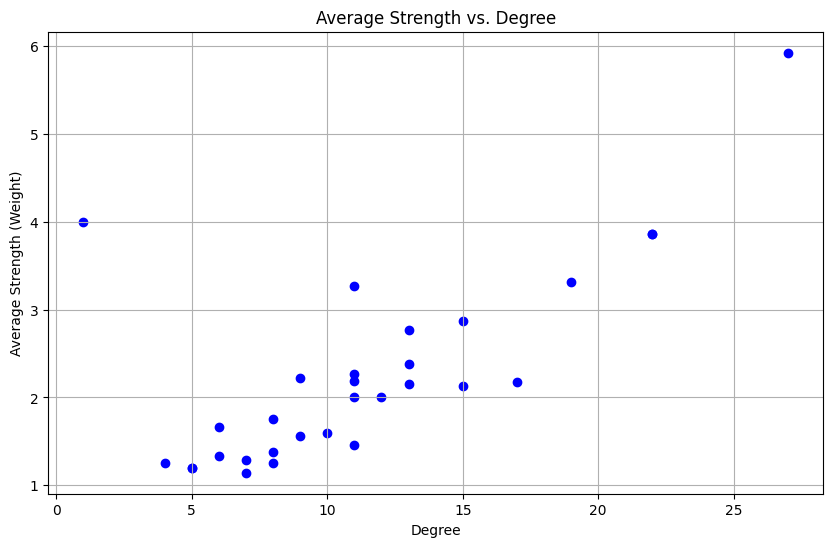

In [39]:
# Calculate average strength for each node
average_strength = {node: 0 for node in G.nodes()}
for node in G.nodes():
    total_weight = sum([attr['weight'] for _, _, attr in G.edges(node, data=True)])
    average_strength[node] = total_weight / G.degree(node)

# Extract degree and average strength for each node
degrees = [G.degree(node) for node in G.nodes()]
average_strengths = [average_strength[node] for node in G.nodes()]

plt.figure(figsize=(10, 6))
plt.scatter(degrees, average_strengths, color='blue')
plt.title("Average Strength vs. Degree")
plt.xlabel("Degree")
plt.ylabel("Average Strength (Weight)")
plt.grid(True)
plt.show()

<b> Analysis </b> <br>

a) 'generative adversarial network' is high degree and high average strength indicating that they are high impact keywords and are likely to be trending topics that are used for future research terms.
<br>
b) 'deep learning' and 'training' are having high degree and moderate average strength indicating that occurs many times and connections are relatively weak.

<b> Final Analysis </b>
<br>
Based on the analysis above for the year 2021, we can see that the focus areas of current research is revolving around these topics - <b> generative adversarial network , deep learning and training </b> . It is likely that future research will continue to evolve around these core areas indicating development in these domains.

### <b> 2022 </b>

For Year 2022 - We are creating Weighted Keyword Co-occurrence Network to check how frequently pairs of keywords co-occur and to understand the strength of their connections.

We initially extract keyword co-occurrence pairs along with their weights before we create the visualization of the network. We are clustering using Louvain method for community detection algorithm to create clusters based on the keywords and using NetworkX package to visualize the network.

a) Extract keyword co-occurrence pairs before creating Keyword Co-occurrence Network

In [40]:
auth_keyword_2022_df['Author Keywords']= auth_keyword_2022_df["Author Keywords"].apply(get_keyword_pairs)
all_pairs = [pair for sublist in auth_keyword_2022_df['Author Keywords'] for pair in sublist]
pair_counts_2022 = Counter(all_pairs)

b) Weighted Keyword Co-Occurrence Network for the year 2022

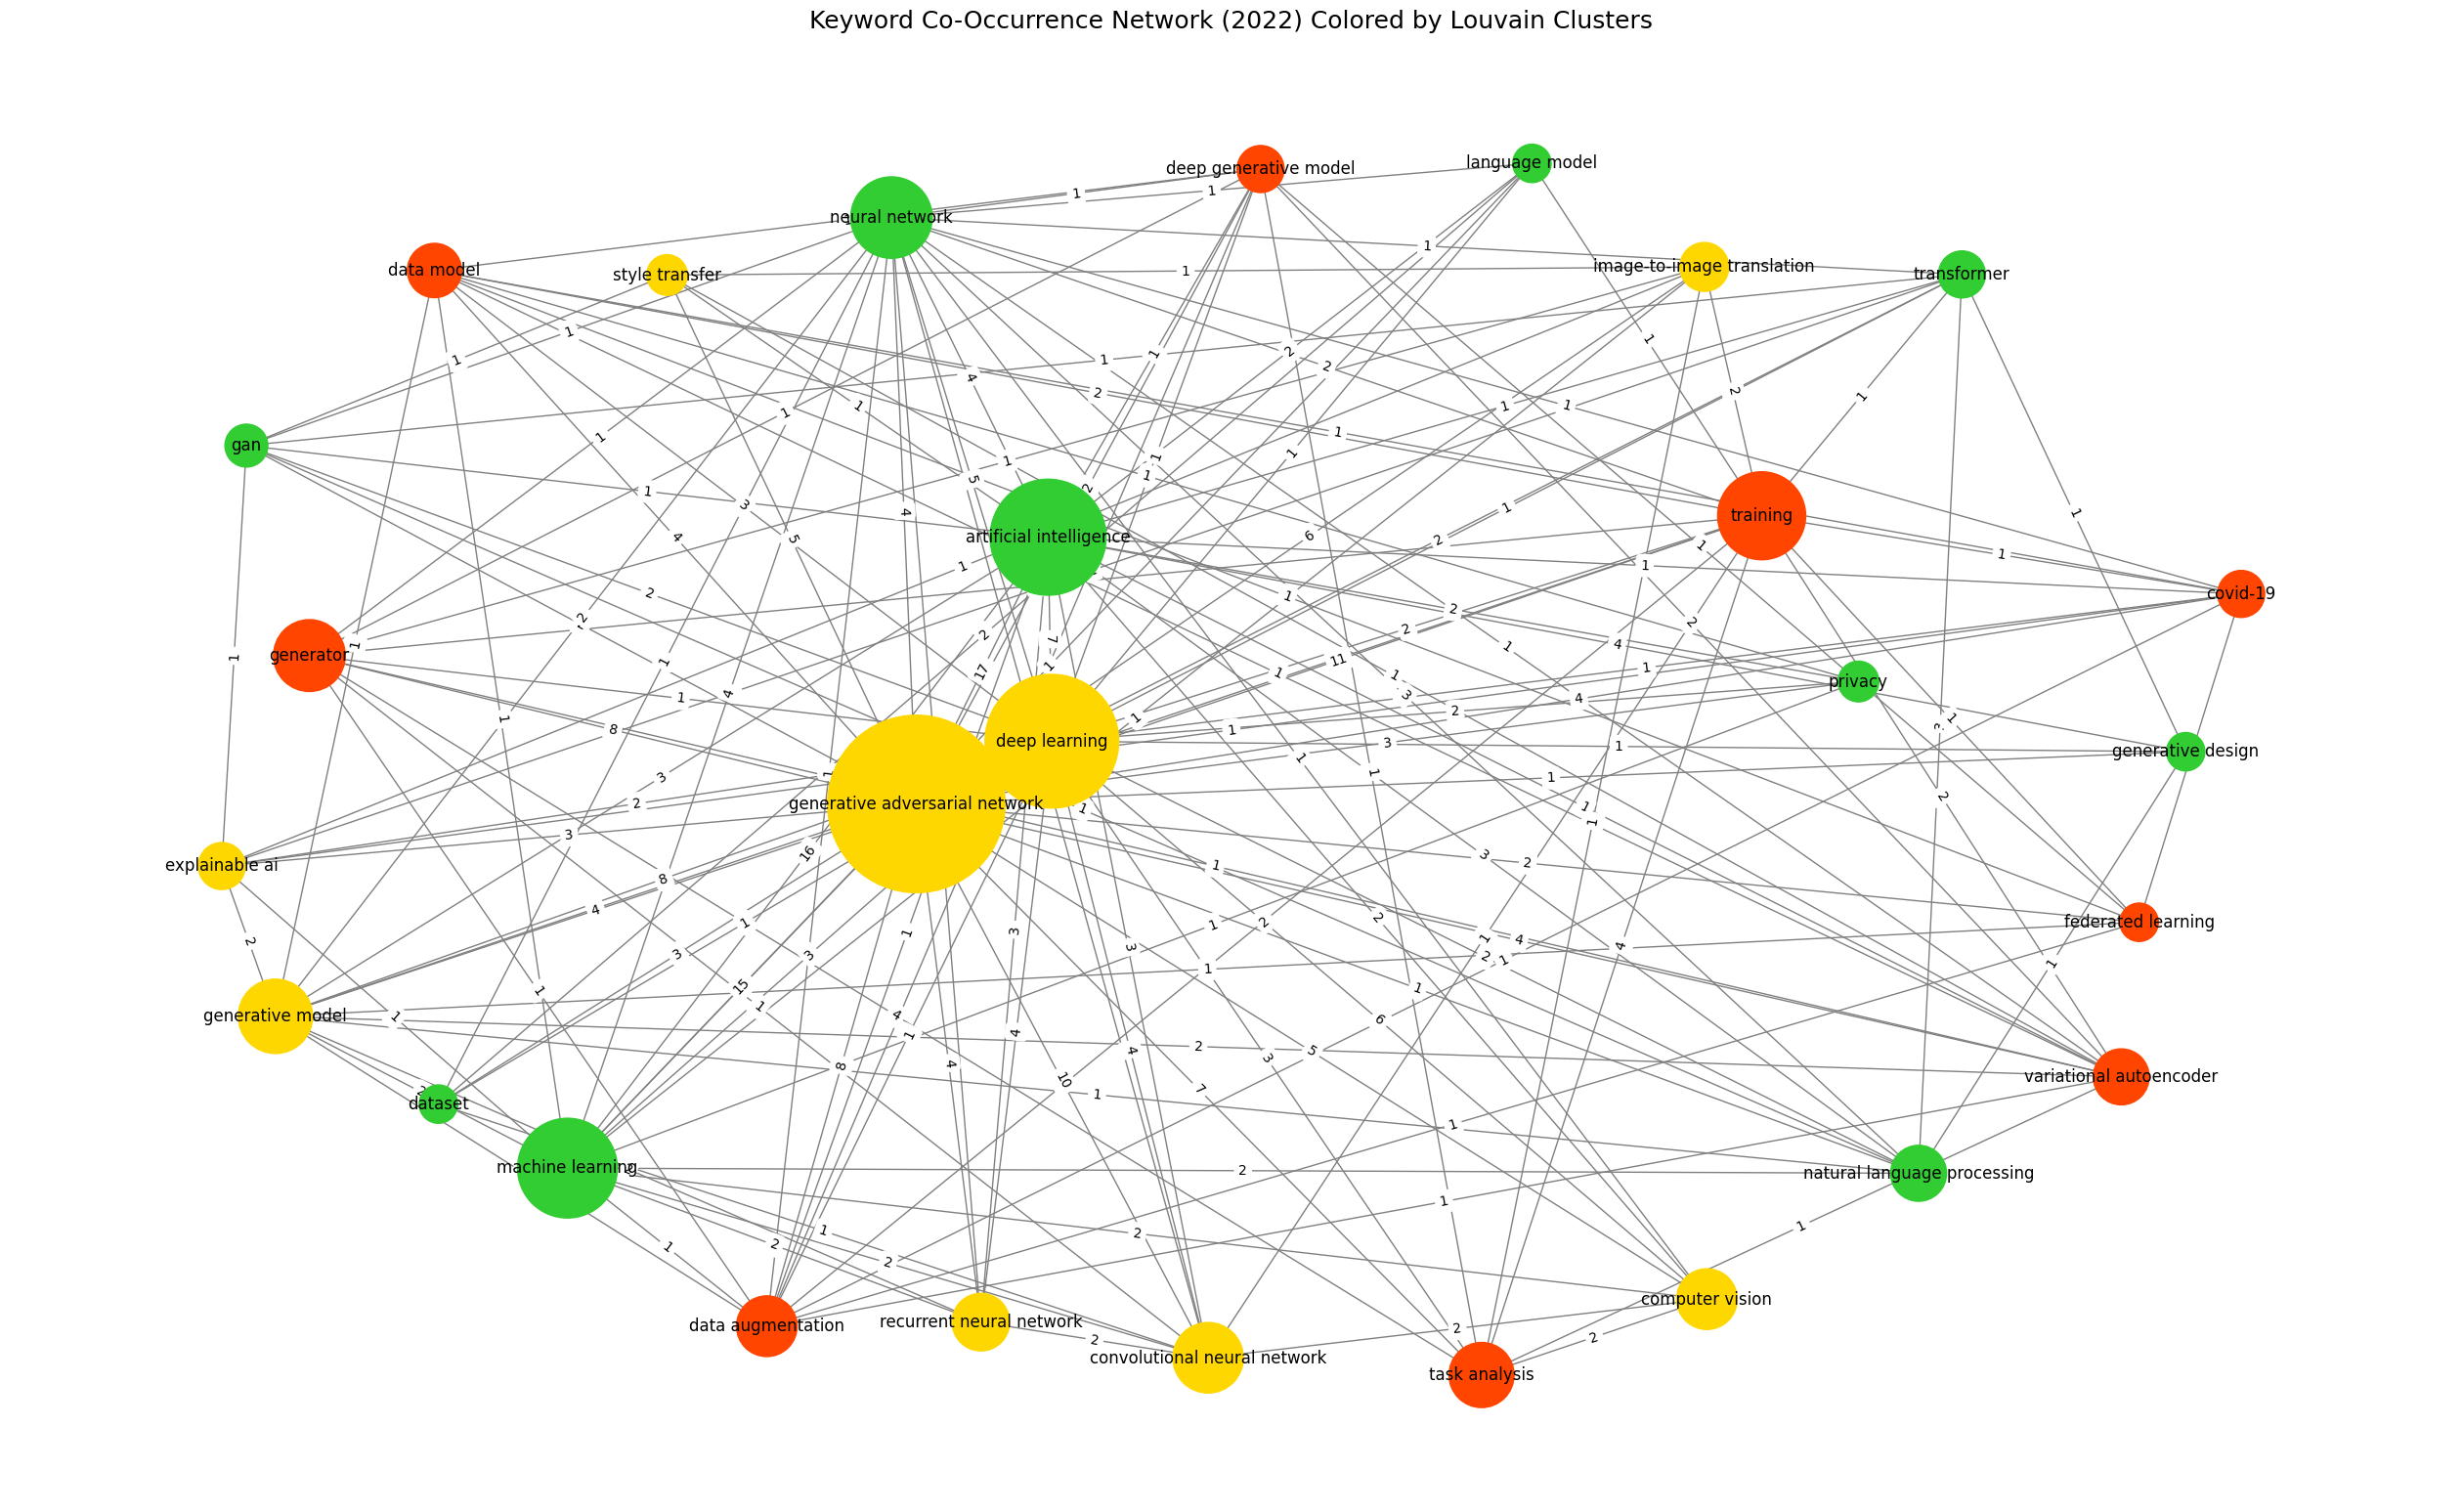

In [74]:
# Create the graph and using Louvain clustering
G_2022 = nx.Graph()
for pair, weight in pair_counts_2022.items():
    G_2022.add_edge(pair[0], pair[1], weight=weight)

pos = nx.spring_layout(G_2022, seed=42, k=4)
partition = community_louvain.best_partition(G_2022)

node_sizes = [100 * G_2022.degree(n, weight='weight') for n in G_2022.nodes()]

custom_colors = ['gold', 'limegreen', 'orangered', 'lightskyblue']
unique_clusters = sorted(set(partition.values()))
cluster_color_map = {cid: custom_colors[i % len(custom_colors)] for i, cid in enumerate(unique_clusters)}
node_colors = [cluster_color_map[partition[node]] for node in G_2022.nodes()]

# Draw network
plt.figure(figsize=(25, 15))
nx.draw(G_2022, pos, with_labels=True, node_size=node_sizes, node_color=node_colors, font_size=12, edge_color="gray")
edge_labels = {(u, v): d.get("weight", 1) for u, v, d in G_2022.edges(data=True)}
nx.draw_networkx_edge_labels(G_2022, pos, edge_labels=edge_labels, font_size=10)

plt.title("Keyword Co-Occurrence Network (2022) Colored by Louvain Clusters", fontsize=18)
plt.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05)
plt.show()


### <b> Analysis - Year 2022 </b>

#### i) Identifying clusters to examine the various research themes or subfields within generative AI, by analyzing which keywords belong to each cluster based on their similarity.

In [73]:
# Create parition and clusters and then group nodes by their cluster ID

partition = community_louvain.best_partition(G_2022)
clusters = defaultdict(list)

for node, cluster_id in partition.items():
    clusters[cluster_id].append(node)

for cluster_id, keywords in clusters.items():
    print(f"Cluster {cluster_id} keywords:")
    print(", ".join(keywords))


Cluster 0 keywords:
artificial intelligence, generative design, machine learning, dataset, natural language processing, neural network, gan, privacy, transformer, language model
Cluster 1 keywords:
generative adversarial network, image-to-image translation, generative model, deep learning, recurrent neural network, computer vision, explainable ai, style transfer, convolutional neural network
Cluster 2 keywords:
data model, variational autoencoder, deep generative model, generator, task analysis, training, data augmentation, federated learning, covid-19


<b> Analysis </b> - The Keywords are being clustered into 3 clusters - 0, 1 and 2 based on their similarity within the broader context of generative AI research.
<br><br>
<u> Cluster 0: </u>  Based on the keywords, the group is mainly related to computer vision and image translation <br>
<u> Cluster 1: </u>  Based on the keywords, the group is mainly related to AI and Neural Networks. <br>
<u> Cluster 2: </u>  Based on the keywords, the group is mainly related to data models and data augmentations.

#### ii) Degree Centrality

In [43]:
# Top 5 Degree Centrality

degree = nx.degree_centrality(G_2022)
top_5_degree = sorted(degree.items(), key=lambda x: x[1], reverse=True)[:5]
print(top_5_degree)

[('generative adversarial network', 0.9629629629629629), ('deep learning', 0.8518518518518519), ('artificial intelligence', 0.7037037037037037), ('neural network', 0.7037037037037037), ('machine learning', 0.5555555555555556)]


<b>Analysis</b>
<br>
a) ‘generative adversarial network’ holds the highest centrality score (0.96), indicating its position as the central hub within the generative AI research.
<br>
b) Closely related terms like ‘artificial intelligence’, ‘deep learning’, and ‘neural network’ also show high centrality, reflecting their role as foundational keywords that frequently co-occur with a wide range of concepts across the generative AI domain.

#### iii) Top 5 Strongest Connections by Weight

In [44]:
# Get Top 5 Keyword pair with highest co-occurrence weights
weighted_edges = [(u, v, d['weight']) for u, v, d in G_2022.edges(data=True)]
top_edges = sorted(weighted_edges, key=lambda x: x[2], reverse=True)[:5]
print("Top 5 Strongest Keyword Connections:")
for u, v, weight in top_edges:
    print(f"{u} ↔ {v} : {weight}")


Top 5 Strongest Keyword Connections:
generative adversarial network ↔ deep learning : 36
artificial intelligence ↔ generative adversarial network : 17
artificial intelligence ↔ machine learning : 16
machine learning ↔ generative adversarial network : 15
generative adversarial network ↔ training : 11


<b>Analysis</b>
<br>
a) The strongest link is ‘generative adversarial network’ and 'deep learning' with a weight of 36.

#### iv) Identification of Key Research Themes - Year 2022

<b> Zipfs law </b>

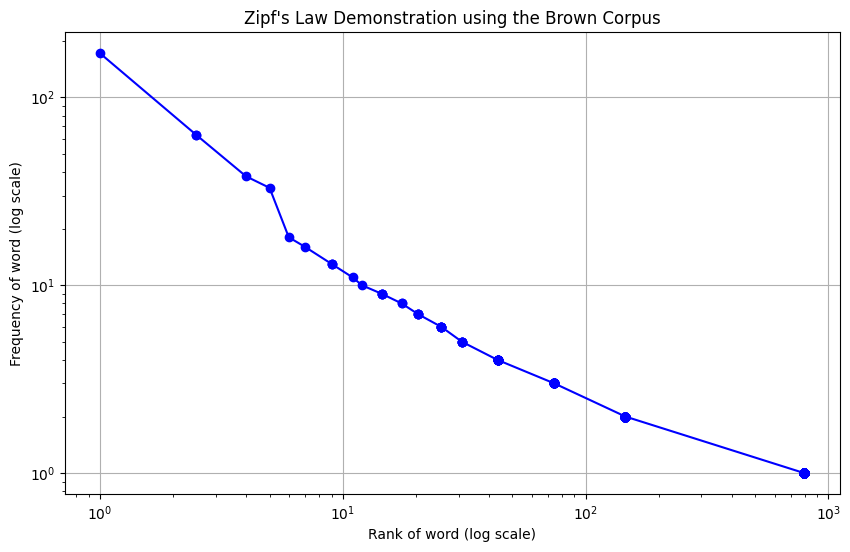

In [45]:
ak_2022_df = extract_author_keywords(wos_2022)
ak_2022_freq_df = pd.DataFrame(Counter([keyword.strip() for sublist in ak_2022_df['Author Keywords'].dropna().str.lower().str.split(', ') for keyword in sublist]).items(), columns=["Keyword", "Frequency"])
ak_2022_freq_df = ak_2022_freq_df.sort_values(by="Frequency", ascending=False)
ak_2022_freq_df['Rank'] = ak_2022_freq_df['Frequency'].rank(ascending=False)

# Plotting Zipfs law

plt.figure(figsize=(10, 6))
plt.loglog(ak_2022_freq_df['Rank'], ak_2022_freq_df['Frequency'], marker='o', linestyle='-', color='b')
plt.title('Zipf\'s Law Demonstration using the Brown Corpus')
plt.xlabel('Rank of word (log scale)')
plt.ylabel('Frequency of word (log scale)')
plt.grid(True)
plt.show()


In [46]:
"""
Zipf Law's Analysis

f(r) = C / r^s

where
f(r) = frequency of the word at rank
r = rank of the word (1 for most frequent, 2 for second most frequent, etc.)
C = normalization constant (depends on the dataset)
s = exponent (usually close to 1 for natural languages)

Results:
Positive deviation → keyword is more frequent than Zipf’s Law expected values → possible emerging topic.
Negative deviation → less frequent than expected.

"""
top_freq = ak_2022_freq_df["Frequency"].iloc[0]
ak_2022_freq_df["Expected_Frequency"] = top_freq / ak_2022_freq_df["Rank"]
ak_2022_freq_df["Deviation"] = ak_2022_freq_df["Frequency"] - ak_2022_freq_df["Expected_Frequency"]
df_sorted_by_deviation = ak_2022_freq_df.sort_values(by="Deviation", ascending=False)

df_sorted_by_deviation

Keyword  Frequency   Rank  Expected_Frequency  \
1144          image classification          2  146.0            1.178082   
1181                   materiality          2  146.0            1.178082   
1021    magnetic resonance imaging          2  146.0            1.178082   
995                 art generation          2  146.0            1.178082   
948               adaptation model          2  146.0            1.178082   
...                            ...        ...    ...                 ...   
4                   explainable ai         13    9.0           19.111111   
205              data augmentation         13    9.0           19.111111   
332   convolutional neural network         13    9.0           19.111111   
162                       training         16    7.0           24.571429   
115                 neural network         18    6.0           28.666667   

      Deviation  
1144   0.821918  
1181   0.821918  
1021   0.821918  
995    0.821918  
948    0.821918  
...         ...  
4     -6.111111  
205   -6.111111  
332   -6.111111  
162   -8.571429  
115  -10.666667  

[1395 rows x 5 columns]

<b>Analysis:</b> <br>
Based on the above analysis, we observe that keywords with a frequency of 2 have a deviation of around 0.82, suggesting that these keywords may be emerging topics for future research.


<b> Avg Weight vs End Point Degree </b>

In [47]:
# Weight of Keyword pairs

G = nx.Graph()

for keyword_list in auth_keyword_2022_list:
    for kw1, kw2 in itertools.combinations(set(keyword_list), 2):
        if G.has_edge(kw1, kw2):
            G[kw1][kw2]['weight'] += 1
        else:
            G.add_edge(kw1, kw2, weight=1)

edges_data = [(u, v, d['weight']) for u, v, d in G.edges(data=True)]
edges_df = pd.DataFrame(edges_data, columns=['Source', 'Target', 'Weight'])
edges_df_sorted = edges_df.sort_values(by='Weight', ascending=False)

edges_df_sorted


Source                          Target  Weight
41   generative adversarial network                   deep learning      36
6           artificial intelligence  generative adversarial network      17
5           artificial intelligence                machine learning      16
23                 machine learning  generative adversarial network      15
54   generative adversarial network                        training      11
..                              ...                             ...     ...
144                  explainable ai                        covid-19       1
145                  explainable ai                             gan       1
146                  explainable ai                     transformer       1
147                  style transfer                             gan       1
148                             gan                     transformer       1

[149 rows x 3 columns]

In [48]:
# Calculate degree and strength for each node
node_stats = []

for node in G.nodes():
    degree = G.degree(node)
    strength = G.degree(node, weight='weight')
    node_stats.append({"Node": node, "Degree": degree, "Strength": strength})

node_stats_df = pd.DataFrame(node_stats)
node_stats_df_sorted = node_stats_df.sort_values(by="Strength", ascending=False)
node_stats_df_sorted.head(10)


Node  Degree  Strength
3   generative adversarial network      26       171
9                    deep learning      23        97
1          artificial intelligence      19        73
2                 machine learning      15        54
17                        training      15        42
15                  neural network      19        36
7                 generative model      13        30
13                       generator      10        28
24    convolutional neural network      10        27
12                   task analysis       8        23

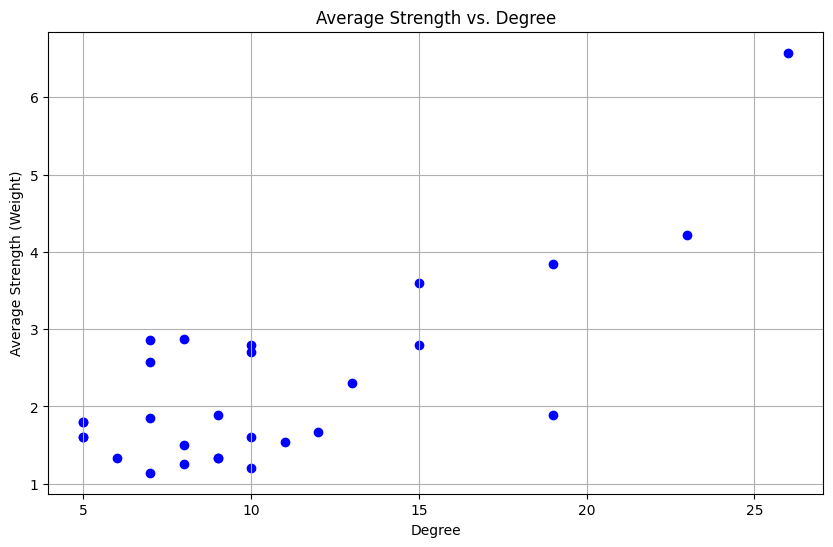

In [49]:
# Calculate average strength for each node
average_strength = {node: 0 for node in G.nodes()}
for node in G.nodes():
    total_weight = sum([attr['weight'] for _, _, attr in G.edges(node, data=True)])
    average_strength[node] = total_weight / G.degree(node)

# Extract degree and average strength for each node
degrees = [G.degree(node) for node in G.nodes()]
average_strengths = [average_strength[node] for node in G.nodes()]

plt.figure(figsize=(10, 6))
plt.scatter(degrees, average_strengths, color='blue')
plt.title("Average Strength vs. Degree")
plt.xlabel("Degree")
plt.ylabel("Average Strength (Weight)")
plt.grid(True)
plt.show()

<b> Analysis </b> <br>

a) 'generative adversarial network' is high degree and high average strength indicating that they are high impact keywords and are likely to be trending topics that are used for future research terms.
<br>
b) 'artificial intelligence', 'machine learning' and 'deep learning' are having high degree and moderate average strength indicating that occurs many times and connections are relatively weak.

<b> Final Analysis </b>
<br>
Based on the analysis above for the year 2022, we can see that the focus areas of current research is revolving around these topics - <b> generative adversarial network , artificial intelligence, machine learning and deep learning </b> . It is likely that future research will continue to evolve around these core areas indicating development in these domains.

### <b> 2023</b>

For Year 2023 - We are creating Weighted Keyword Co-occurrence Network to check how frequently pairs of keywords co-occur and to understand the strength of their connections.

We initially extract keyword co-occurrence pairs along with their weights before we create the visualization of the network. We are clustering using Louvain method for community detection algorithm to create clusters based on the keywords and using NetworkX package to visualize the network.

a) Extract keyword co-occurrence pairs before creating Keyword Co-occurrence Network

In [50]:
auth_keyword_2023_df['Author Keywords']= auth_keyword_2023_df["Author Keywords"].apply(get_keyword_pairs)
all_pairs = [pair for sublist in auth_keyword_2023_df['Author Keywords'] for pair in sublist]
pair_counts_2023 = Counter(all_pairs)

b) Weighted Keyword Co-Occurrence Network for the year 2023

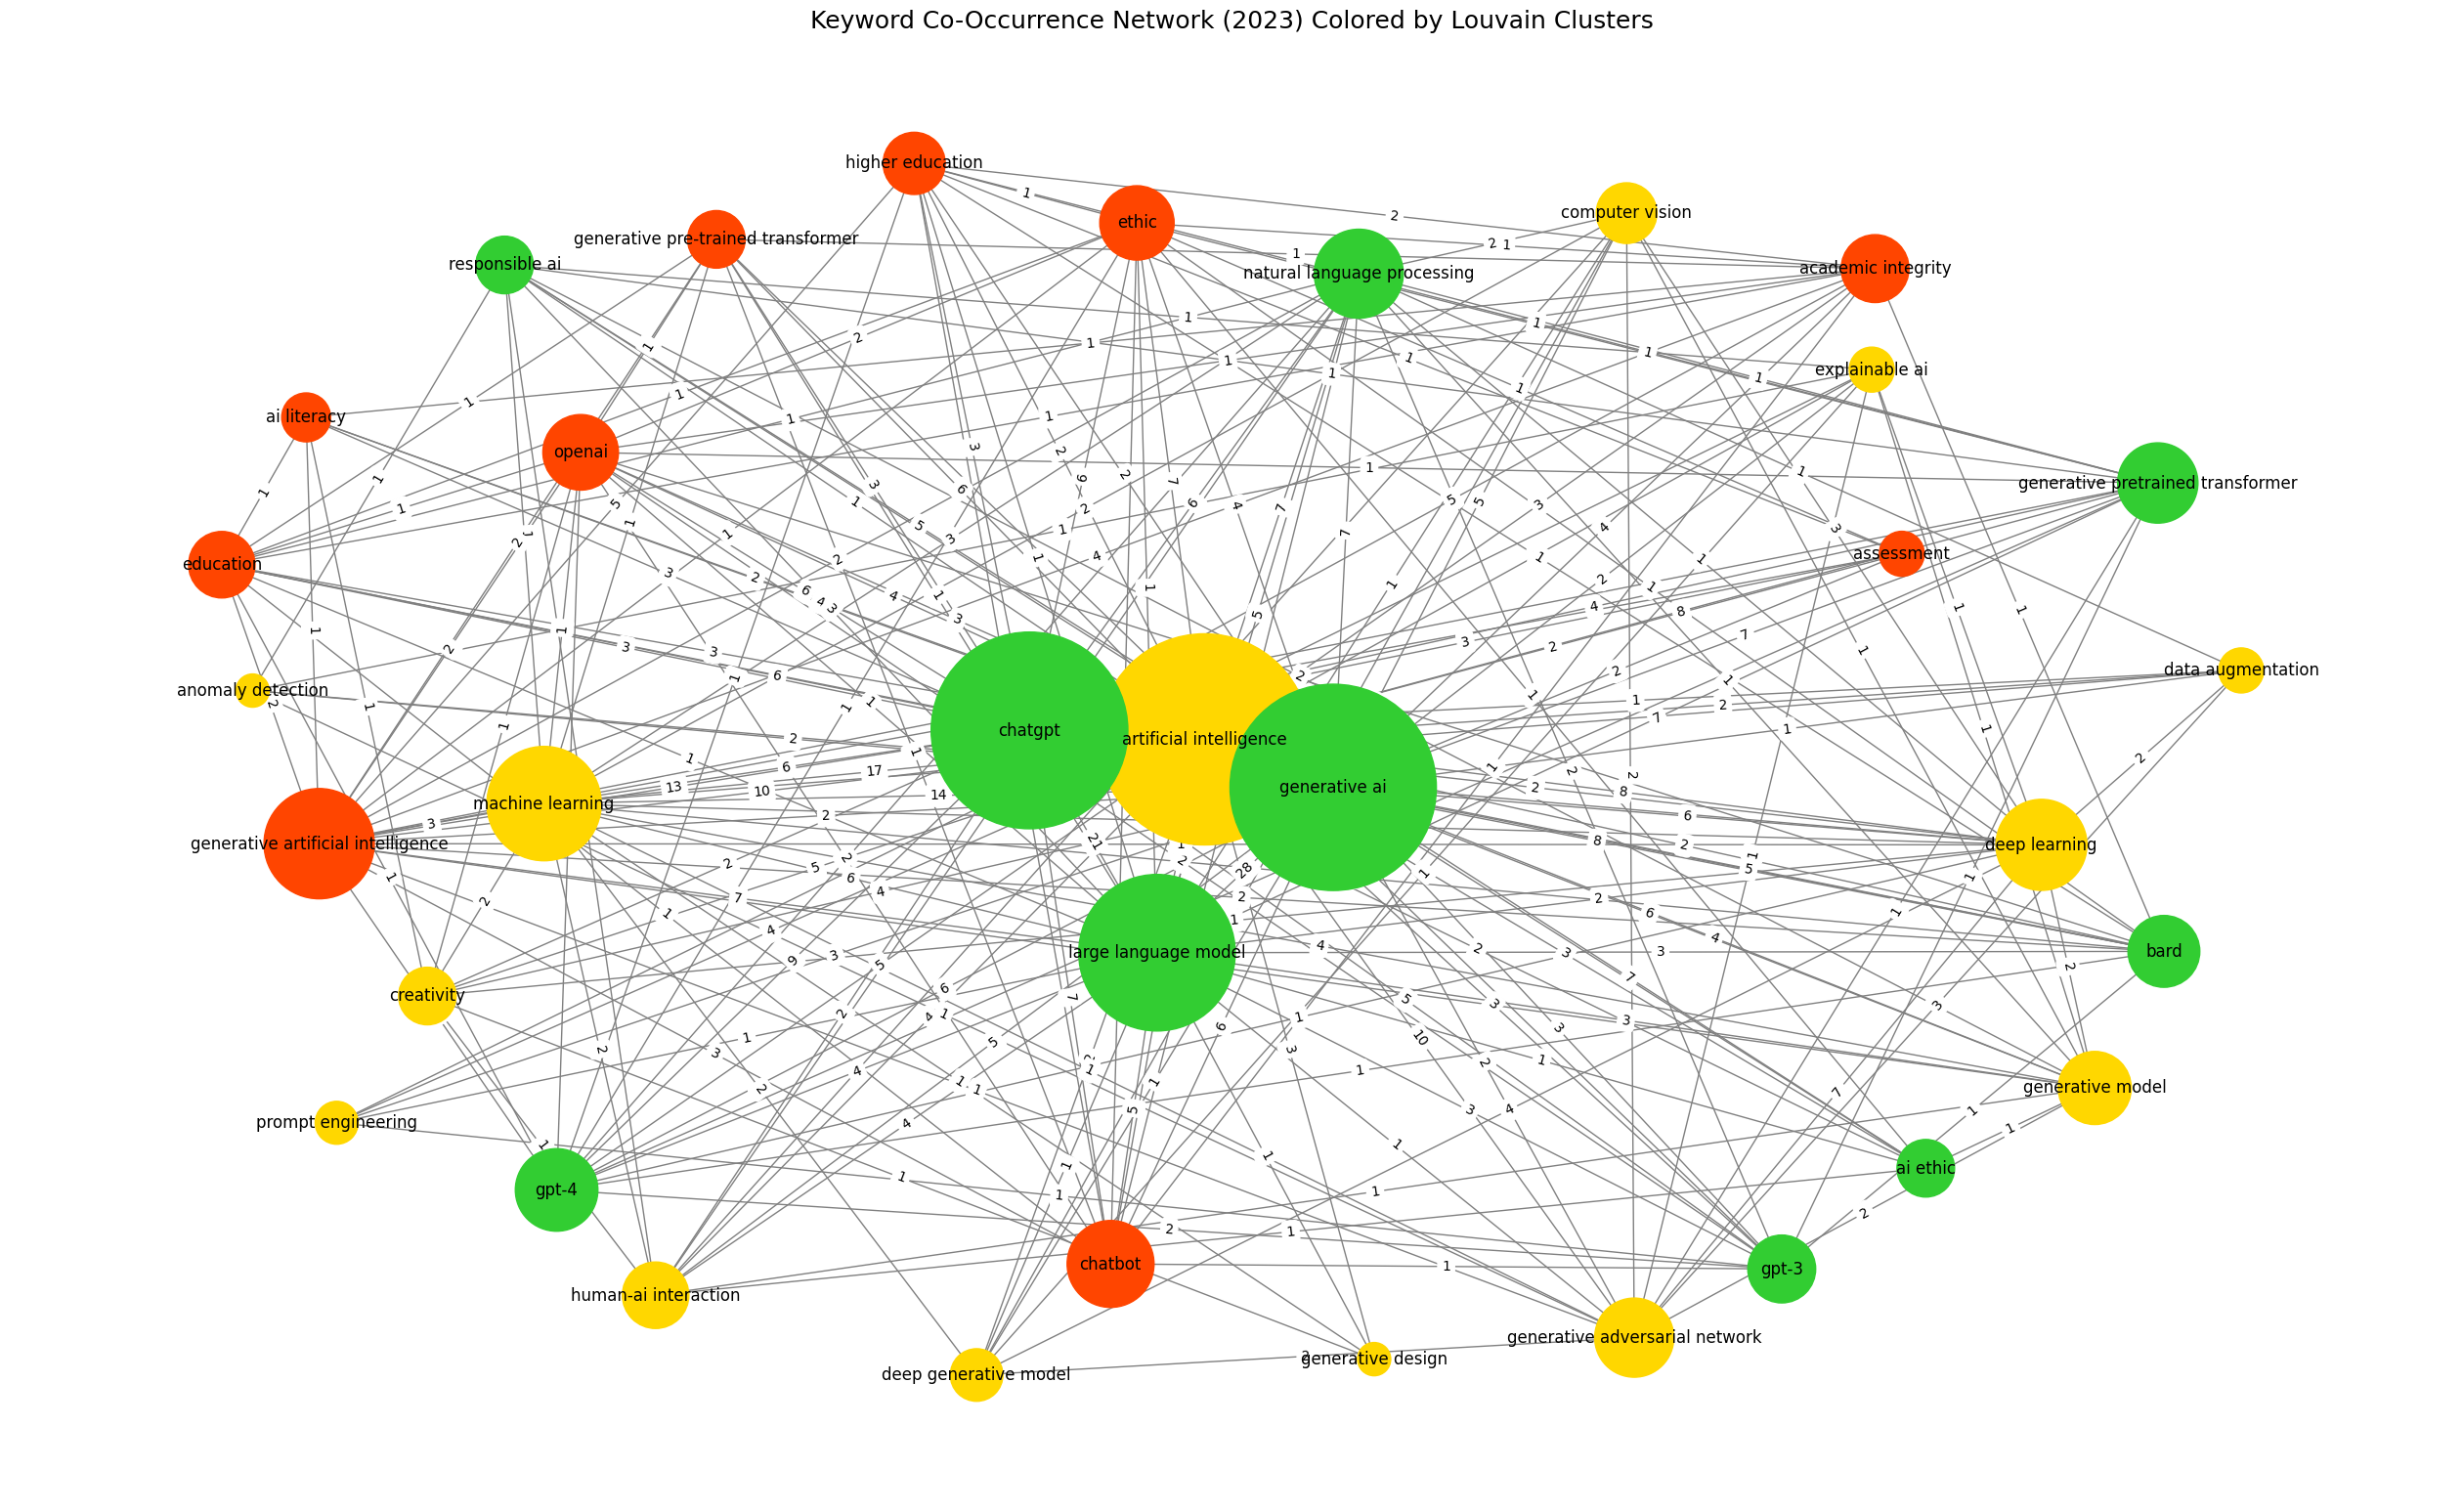

In [76]:
# Create the graph and using Louvain clustering
G_2023 = nx.Graph()
for pair, weight in pair_counts_2023.items():
    G_2023.add_edge(pair[0], pair[1], weight=weight)

pos = nx.spring_layout(G_2023, seed=42, k=4)
partition = community_louvain.best_partition(G_2023)

node_sizes = [100 * G_2023.degree(n, weight='weight') for n in G_2023.nodes()]

custom_colors = ['gold', 'limegreen', 'orangered', 'lightskyblue']
unique_clusters = sorted(set(partition.values()))
cluster_color_map = {cid: custom_colors[i % len(custom_colors)] for i, cid in enumerate(unique_clusters)}
node_colors = [cluster_color_map[partition[node]] for node in G_2023.nodes()]

# Draw network
plt.figure(figsize=(25, 15))
nx.draw(G_2023, pos, with_labels=True, node_size=node_sizes, node_color=node_colors, font_size=12, edge_color="gray")
edge_labels = {(u, v): d.get("weight", 1) for u, v, d in G_2023.edges(data=True)}
nx.draw_networkx_edge_labels(G_2023, pos, edge_labels=edge_labels, font_size=10)

plt.title("Keyword Co-Occurrence Network (2023) Colored by Louvain Clusters", fontsize=18)
plt.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05)
plt.show()


### <b> Analysis - Year 2023</b>

#### i) Identifying clusters to examine the various research themes or subfields within generative AI, by analyzing which keywords belong to each cluster based on their similarity.

In [75]:
# Create parition and clusters and then group nodes by their cluster ID

partition = community_louvain.best_partition(G_2023)
clusters = defaultdict(list)

for node, cluster_id in partition.items():
    clusters[cluster_id].append(node)

for cluster_id, keywords in clusters.items():
    print(f"Cluster {cluster_id} keywords:")
    print(", ".join(keywords))


Cluster 0 keywords:
artificial intelligence, human-ai interaction, explainable ai, generative model, creativity, anomaly detection, generative adversarial network, deep generative model, deep learning, machine learning, generative design, data augmentation, computer vision, prompt engineering
Cluster 1 keywords:
generative ai, responsible ai, large language model, chatgpt, gpt-3, gpt-4, natural language processing, ai ethic, generative pretrained transformer, bard
Cluster 2 keywords:
education, higher education, ai literacy, ethic, assessment, academic integrity, generative artificial intelligence, chatbot, openai, generative pre-trained transformer


<b> Analysis </b> - The Keywords are being clustered into 3 clusters - 0, 1 and 2 based on their similarity within the broader context of generative AI research.
<br><br>
<u> Cluster 0: </u>  Based on the keywords, the group is mainly related to academic integrity and ethics for AI in education sector <br>
<u> Cluster 1: </u>  Based on the keywords, the group is mainly related to AI and its AI chatbots such as ChatGPT   <br>
<u> Cluster 2: </u>  Based on the keywords, the group is mainly related to generative models and deep learning

#### ii) Degree Centrality

In [53]:
# Top 5 Degree Centrality

degree = nx.degree_centrality(G_2023)
top_5_degree = sorted(degree.items(), key=lambda x: x[1], reverse=True)[:5]
print(top_5_degree)

[('artificial intelligence', 0.9393939393939394), ('generative ai', 0.9393939393939394), ('large language model', 0.7878787878787878), ('chatgpt', 0.7272727272727273), ('generative artificial intelligence', 0.6363636363636364)]


<b>Analysis</b>
<br>
a) ‘artificial intelligence’ and 'generative ai' holds the highest centrality score (0.93), indicating its position as the central hub within the generative AI research.
<br>
b) Closely related terms like ‘large language model’ and ‘chatgpt’ also show high centrality, reflecting their role as foundational keywords that frequently co-occur with a wide range of concepts across the generative AI domain.

#### iii) Top 5 Strongest Connections by Weight

In [54]:
# Get Top 5 Keyword pair with highest co-occurrence weights
weighted_edges = [(u, v, d['weight']) for u, v, d in G_2023.edges(data=True)]
top_edges = sorted(weighted_edges, key=lambda x: x[2], reverse=True)[:5]
print("Top 5 Strongest Keyword Connections:")
for u, v, weight in top_edges:
    print(f"{u} ↔ {v} : {weight}")


Top 5 Strongest Keyword Connections:
generative ai ↔ chatgpt : 46
artificial intelligence ↔ chatgpt : 44
artificial intelligence ↔ generative ai : 35
generative ai ↔ large language model : 28
artificial intelligence ↔ large language model : 21


<b>Analysis</b>
<br>
a) The strongest linksare ‘generative ai’ and ‘chatgpt’ with a weight of 46.

#### iv) Identification of Key Research Themes - Year 2023

<b> Zipfs law </b>

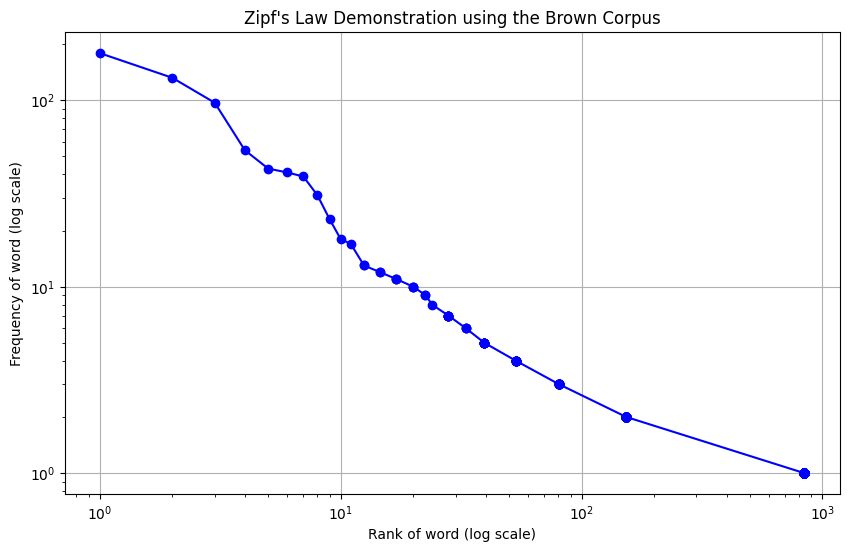

In [55]:
ak_2023_df = extract_author_keywords(wos_2023)
ak_2023_freq_df = pd.DataFrame(Counter([keyword.strip() for sublist in ak_2023_df['Author Keywords'].dropna().str.lower().str.split(', ') for keyword in sublist]).items(), columns=["Keyword", "Frequency"])
ak_2023_freq_df = ak_2023_freq_df.sort_values(by="Frequency", ascending=False)
ak_2023_freq_df['Rank'] = ak_2023_freq_df['Frequency'].rank(ascending=False)

# Plotting Zipfs law

plt.figure(figsize=(10, 6))
plt.loglog(ak_2023_freq_df['Rank'], ak_2023_freq_df['Frequency'], marker='o', linestyle='-', color='b')
plt.title('Zipf\'s Law Demonstration using the Brown Corpus')
plt.xlabel('Rank of word (log scale)')
plt.ylabel('Frequency of word (log scale)')
plt.grid(True)
plt.show()


In [56]:
"""
Zipf Law's Analysis

f(r) = C / r^s

where
f(r) = frequency of the word at rank
r = rank of the word (1 for most frequent, 2 for second most frequent, etc.)
C = normalization constant (depends on the dataset)
s = exponent (usually close to 1 for natural languages)

Results:
Positive deviation → keyword is more frequent than Zipf’s Law expected values → possible emerging topic.
Negative deviation → less frequent than expected.

"""
top_freq = ak_2023_freq_df["Frequency"].iloc[0]
ak_2023_freq_df["Expected_Frequency"] = top_freq / ak_2023_freq_df["Rank"]
ak_2023_freq_df["Deviation"] = ak_2023_freq_df["Frequency"] - ak_2023_freq_df["Expected_Frequency"]
df_sorted_by_deviation = ak_2023_freq_df.sort_values(by="Deviation", ascending=False)

df_sorted_by_deviation

Keyword  Frequency  Rank  Expected_Frequency  \
0               artificial intelligence        132   2.0           89.500000   
25                              chatgpt         97   3.0           59.666667   
15                     generative model         39   7.0           25.571429   
233  generative artificial intelligence         41   6.0           29.833333   
17                 large language model         54   4.0           44.750000   
..                                  ...        ...   ...                 ...   
1                         generative ai        179   1.0          179.000000   
5                             education         12  14.5           12.344828   
119               deep generative model         12  14.5           12.344828   
9                        explainable ai         13  12.5           14.320000   
96    generative pretrained transformer         13  12.5           14.320000   

     Deviation  
0    42.500000  
25   37.333333  
15   13.428571  
233  11.166667  
17    9.250000  
..         ...  
1     0.000000  
5    -0.344828  
119  -0.344828  
9    -1.320000  
96   -1.320000  

[1474 rows x 5 columns]

<b>Analysis:</b> <br>
Based on the above analysis, we observe that 'artificial intelligence' with a frequency of 132 have a deviation of around 42 and 'chatgpt' with a frequency of 97 have a deviation of around 37, suggesting that these keywords may be emerging topics for future research.


<b> Avg Weight vs End Point Degree </b>

In [57]:
# Weight of Keyword pairs

G = nx.Graph()

for keyword_list in auth_keyword_2023_list:
    for kw1, kw2 in itertools.combinations(set(keyword_list), 2):
        if G.has_edge(kw1, kw2):
            G[kw1][kw2]['weight'] += 1
        else:
            G.add_edge(kw1, kw2, weight=1)

edges_data = [(u, v, d['weight']) for u, v, d in G.edges(data=True)]
edges_df = pd.DataFrame(edges_data, columns=['Source', 'Target', 'Weight'])
edges_df_sorted = edges_df.sort_values(by='Weight', ascending=False)

edges_df_sorted


Source                              Target  Weight
8              generative ai                             chatgpt      46
37   artificial intelligence                             chatgpt      44
0              generative ai             artificial intelligence      35
6              generative ai                large language model      28
34   artificial intelligence                large language model      21
..                       ...                                 ...     ...
213       academic integrity                              openai       1
210                    ethic                                bard       1
223                  chatbot  generative pre-trained transformer       1
224                   openai                                bard       1
225                   openai  generative pre-trained transformer       1

[226 rows x 3 columns]

In [58]:
# Calculate degree and strength for each node
node_stats = []

for node in G.nodes():
    degree = G.degree(node)
    strength = G.degree(node, weight='weight')
    node_stats.append({"Node": node, "Degree": degree, "Strength": strength})

node_stats_df = pd.DataFrame(node_stats)
node_stats_df_sorted = node_stats_df.sort_values(by="Strength", ascending=False)
node_stats_df_sorted.head(10)


Node  Degree  Strength
1              artificial intelligence      31       242
0                        generative ai      31       231
9                              chatgpt      24       210
7                 large language model      26       133
20                    machine learning      19        71
29  generative artificial intelligence      21        66
18                       deep learning      16        45
12         natural language processing      16        43
30                             chatbot      13        41
10                               gpt-4      14        37

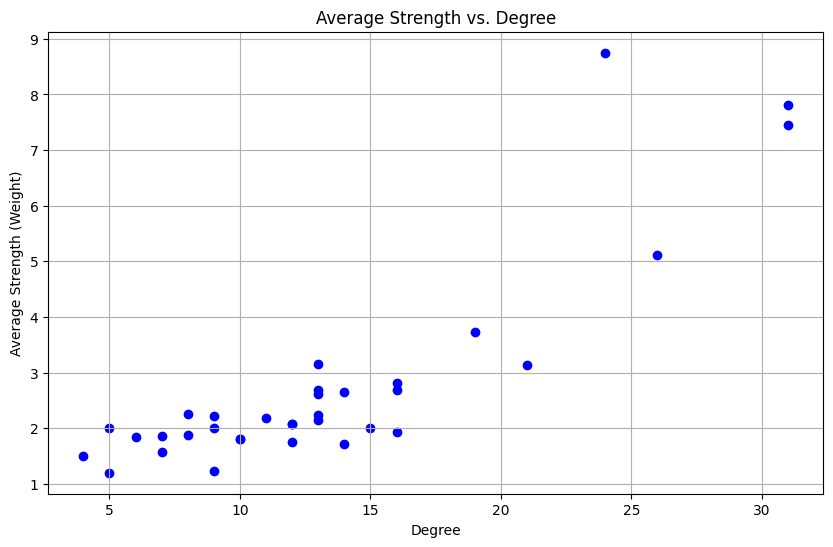

In [59]:
# Calculate average strength for each node
average_strength = {node: 0 for node in G.nodes()}
for node in G.nodes():
    total_weight = sum([attr['weight'] for _, _, attr in G.edges(node, data=True)])
    average_strength[node] = total_weight / G.degree(node)

# Extract degree and average strength for each node
degrees = [G.degree(node) for node in G.nodes()]
average_strengths = [average_strength[node] for node in G.nodes()]

plt.figure(figsize=(10, 6))
plt.scatter(degrees, average_strengths, color='blue')
plt.title("Average Strength vs. Degree")
plt.xlabel("Degree")
plt.ylabel("Average Strength (Weight)")
plt.grid(True)
plt.show()

<b> Analysis </b> <br>

a) 'artificial intelligence' and 'generative ai' are having high degree and high average strength indicating that they are high impact keywords and are likely to be trending topics that are used for future research terms.
<br>
b) 'large language model' and 'chatgpt' are having high degree and moderate average strength indicating that occurs many times and connections are relatively strong.

<b> Final Analysis </b>
<br>
Based on the analysis above for the year 2023, we can see that the focus areas of current research is revolving around these topics - <b> generative ai , artificial intelligence, chatgpt and large language model</b> . It is likely that future research will continue to evolve around these core areas indicating development in these domains.

### <b> 2024 </b>

For Year 2024 - We are creating Weighted Keyword Co-occurrence Network to check how frequently pairs of keywords co-occur and to understand the strength of their connections.

We initially extract keyword co-occurrence pairs along with their weights before we create the visualization of the network. We are clustering using Louvain method for community detection algorithm to create clusters based on the keywords and using NetworkX package to visualize the network.

a) Extract keyword co-occurrence pairs before creating Keyword Co-occurrence Network

In [60]:
auth_keyword_2024_df['Author Keywords']= auth_keyword_2024_df["Author Keywords"].apply(get_keyword_pairs)
all_pairs = [pair for sublist in auth_keyword_2024_df['Author Keywords'] for pair in sublist]
pair_counts_2024 = Counter(all_pairs)

b) Weighted Keyword Co-Occurrence Network for the year 2024

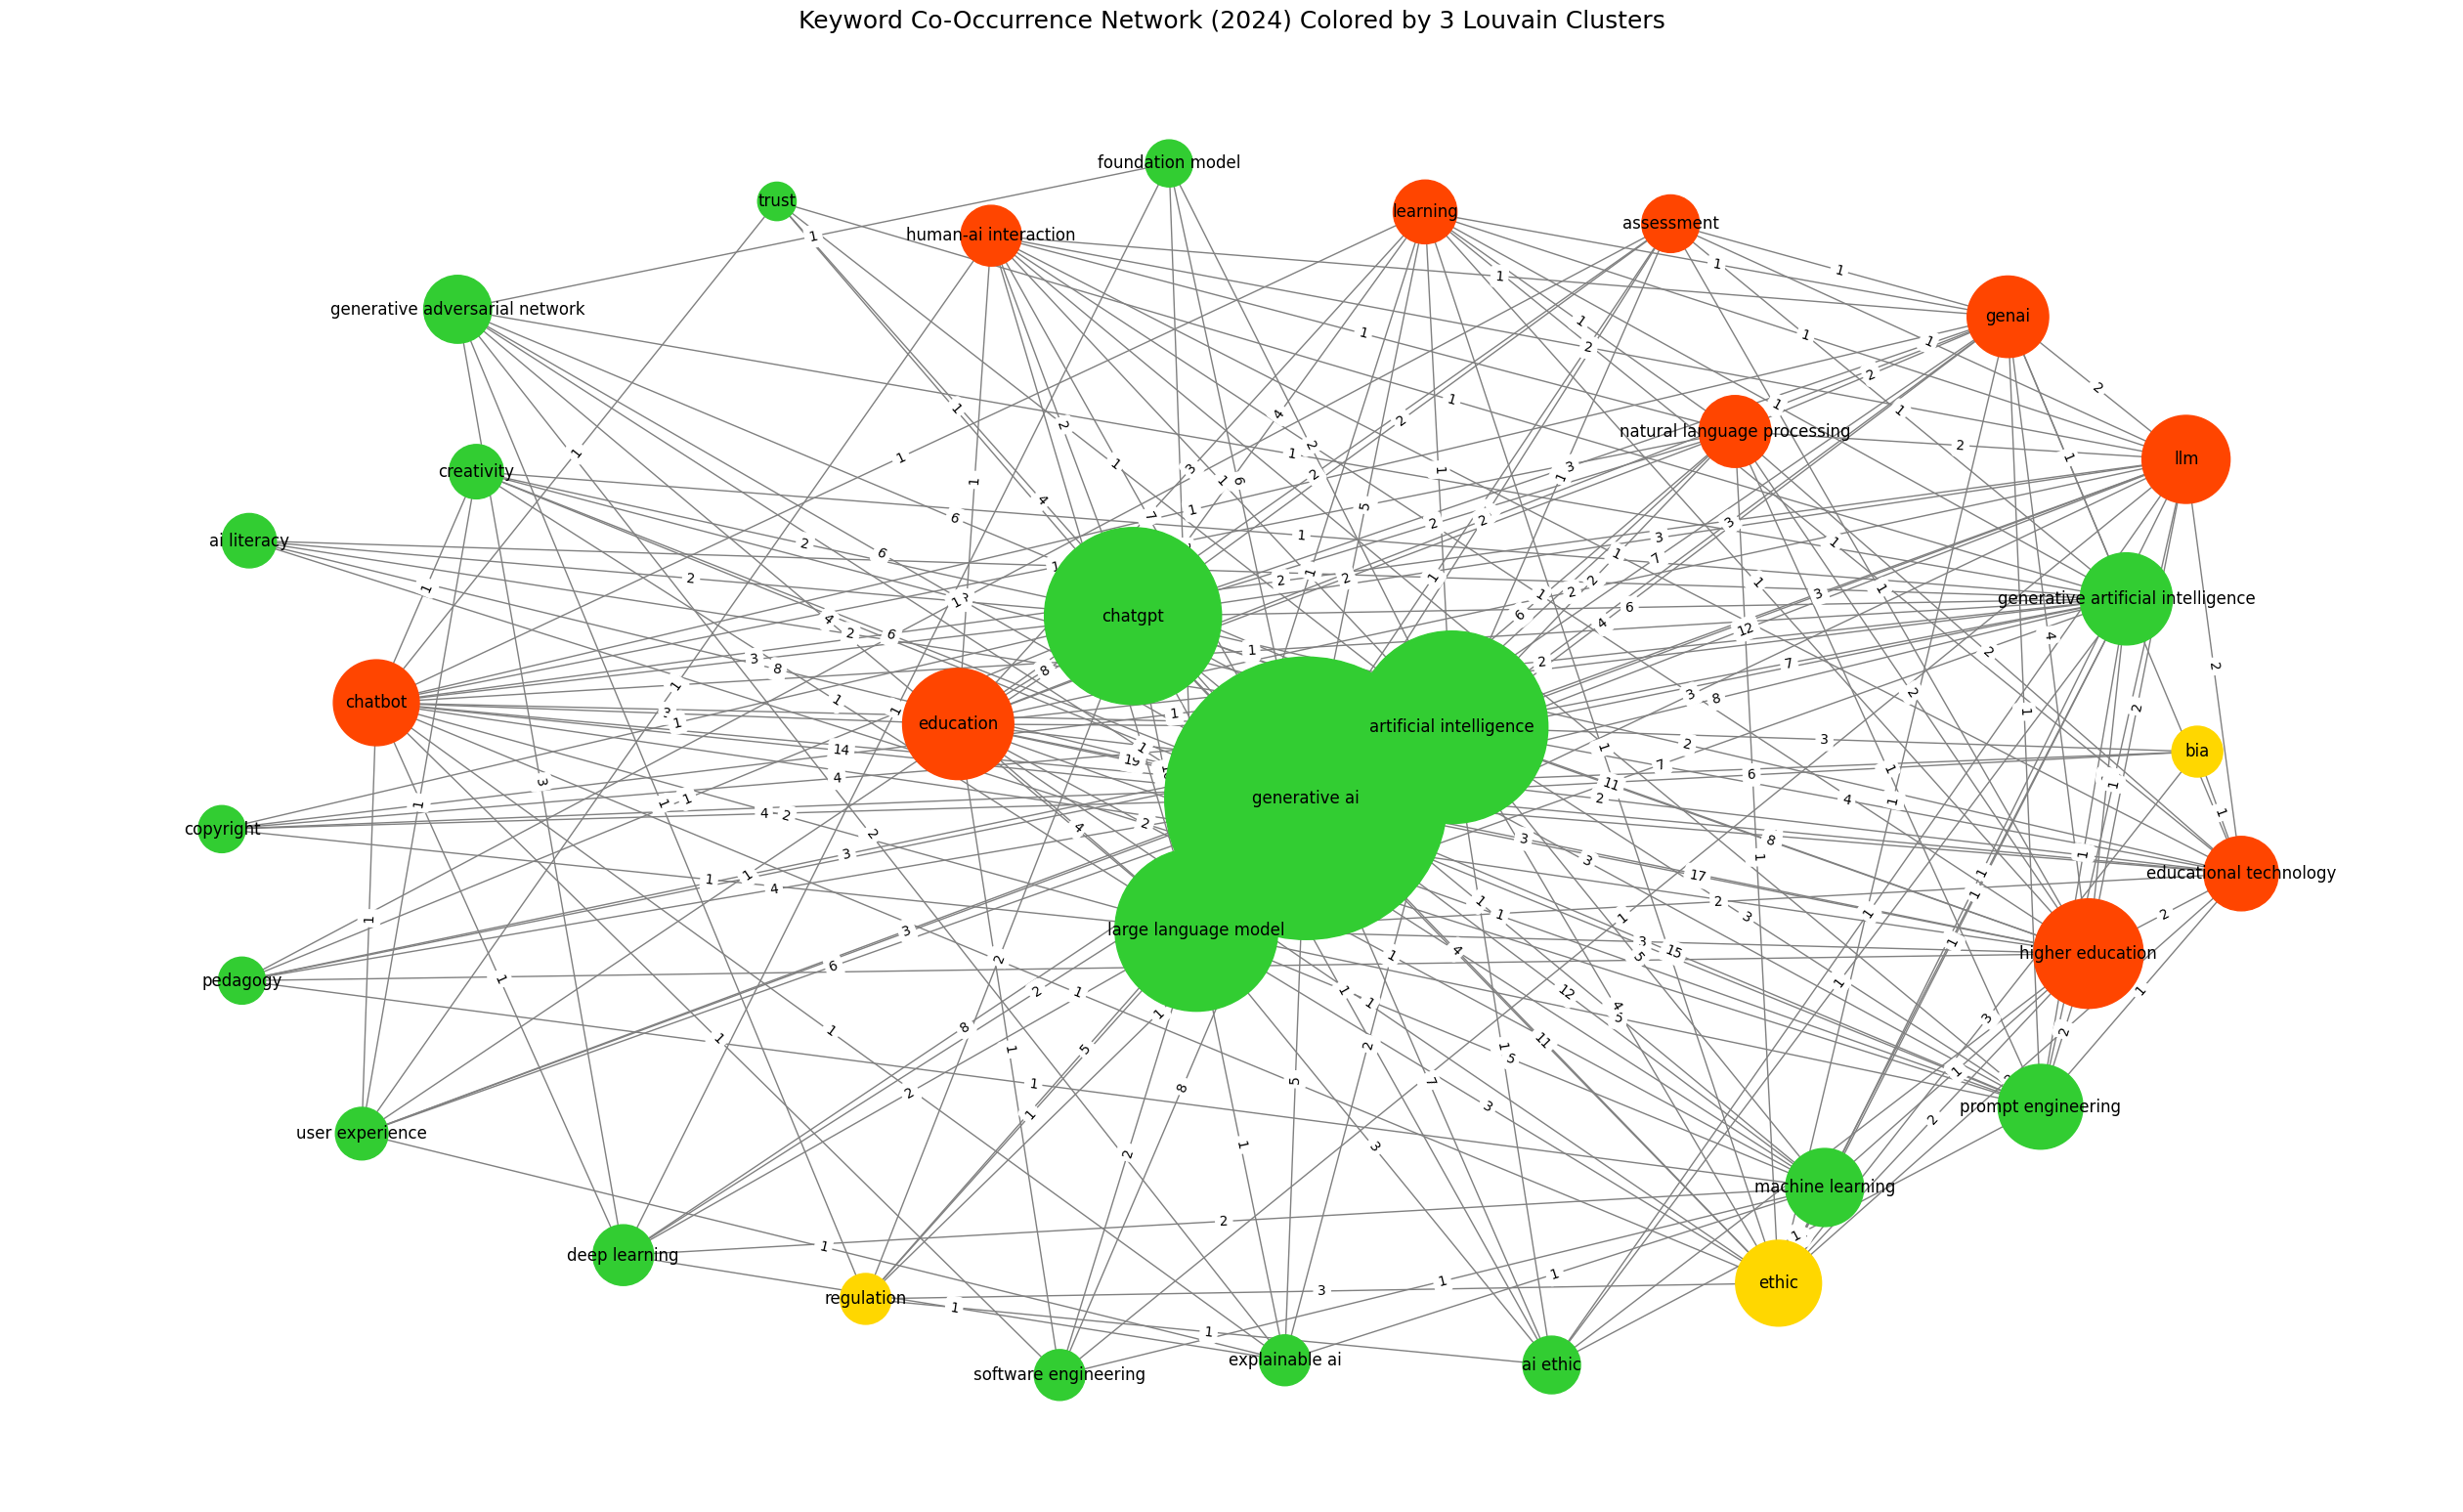

In [61]:
# Create the graph and using Louvain clustering
G_2024 = nx.Graph()
for pair, weight in pair_counts_2024.items():
    G_2024.add_edge(pair[0], pair[1], weight=weight)

pos = nx.spring_layout(G_2024, seed=42, k=4)
partition = community_louvain.best_partition(G_2024)

node_sizes = [100 * G_2024.degree(n, weight='weight') for n in G_2024.nodes()]

custom_colors = ['gold', 'limegreen', 'orangered']
unique_clusters = sorted(set(partition.values()))
cluster_color_map = {cid: custom_colors[i % len(custom_colors)] for i, cid in enumerate(unique_clusters)}
node_colors = [cluster_color_map[partition[node]] for node in G_2024.nodes()]

# Draw network
plt.figure(figsize=(25, 15))
nx.draw(G_2024, pos, with_labels=True, node_size=node_sizes, node_color=node_colors, font_size=12, edge_color="gray")
edge_labels = {(u, v): d.get("weight", 1) for u, v, d in G_2024.edges(data=True)}
nx.draw_networkx_edge_labels(G_2024, pos, edge_labels=edge_labels, font_size=10)

plt.title("Keyword Co-Occurrence Network (2024) Colored by 3 Louvain Clusters", fontsize=18)
plt.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05)
plt.show()


### <b> Analysis - Year 2024</b>

#### i) Identifying clusters to examine the various research themes or subfields within generative AI, by analyzing which keywords belong to each cluster based on their similarity.

In [62]:
# Create parition and clusters and then group nodes by their cluster ID

partition = community_louvain.best_partition(G_2024)
clusters = defaultdict(list)

for node, cluster_id in partition.items():
    clusters[cluster_id].append(node)

for cluster_id, keywords in clusters.items():
    print(f"Cluster {cluster_id} keywords:")
    print(", ".join(keywords))


Cluster 0 keywords:
foundation model, generative ai, large language model, ai literacy, artificial intelligence, generative adversarial network, deep learning, creativity, machine learning, ai ethic, prompt engineering, trust, software engineering, copyright, chatgpt, explainable ai, generative artificial intelligence, user experience, pedagogy
Cluster 2 keywords:
higher education, education, learning, chatbot, llm, human-ai interaction, natural language processing, genai, assessment, educational technology
Cluster 1 keywords:
ethic, bia, regulation


<b> Analysis </b> - The Keywords are being clustered into 3 clusters - 0, 1 and 2 based on their similarity within the broader context of generative AI research.
<br><br>
<u> Cluster 0: </u>  Based on the keywords, the group is mainly related to core technologies and methodologies driving generative AI. <br>
<u> Cluster 1: </u>  Based on the keywords, the group is mainly related to ethical, legal and societal implications of generative AI. <br>
<u> Cluster 2: </u>  Based on the keywords, the group is mainly related to application of generative AI in educational contexts.

#### ii) Degree Centrality

In [63]:
# Top 5 Degree Centrality

degree = nx.degree_centrality(G_2024)
top_5_degree = sorted(degree.items(), key=lambda x: x[1], reverse=True)[:5]
print(top_5_degree)

[('generative ai', 1.0), ('artificial intelligence', 0.967741935483871), ('large language model', 0.8387096774193548), ('chatgpt', 0.8064516129032258), ('generative artificial intelligence', 0.6451612903225806)]


<b>Analysis</b>
<br>
a) ‘generative ai’ holds the highest centrality score (1.0), indicating its position as the central hub within the generative AI research.
<br>
b) Closely related terms like ‘artificial intelligence’, ‘large language model’, and ‘chatgpt’ also show high centrality, reflecting their role as foundational keywords that frequently co-occur with a wide range of concepts across the generative AI domain.

#### iii) Top 5 Strongest Connections by Weight

In [64]:
# Get Top 5 Keyword pair with highest co-occurrence weights
weighted_edges = [(u, v, d['weight']) for u, v, d in G_2024.edges(data=True)]
top_edges = sorted(weighted_edges, key=lambda x: x[2], reverse=True)[:5]
print("Top 5 Strongest Keyword Connections:")
for u, v, weight in top_edges:
    print(f"{u} ↔ {v} : {weight}")


Top 5 Strongest Keyword Connections:
generative ai ↔ artificial intelligence : 75
generative ai ↔ chatgpt : 75
generative ai ↔ large language model : 55
artificial intelligence ↔ chatgpt : 20
generative ai ↔ education : 19


<b>Analysis</b>
<br>
a) The strongest links with ‘artificial intelligence’ and ‘chatgpt’ with a weight of 75 suggest that generative ai is being studied both as rise of foundational AI and with AI chatbot application like ChatGPT.

#### iv) Identification of Key Research Themes - Year 2024

<b> Zipfs law </b>

<ipython-input-8-3c6e6621d377>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wos_new_df["Author Keywords"] = wos_new_df["Author Keywords"].astype(str).str.lower()
<ipython-input-8-3c6e6621d377>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wos_new_df['Author Keywords'] = wos_new_df['Author Keywords'].replace(to_replace=r'\(\s*[^)]+\s*\)', value='', regex=True)
<ipython-input-8-3c6e6621d377>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc

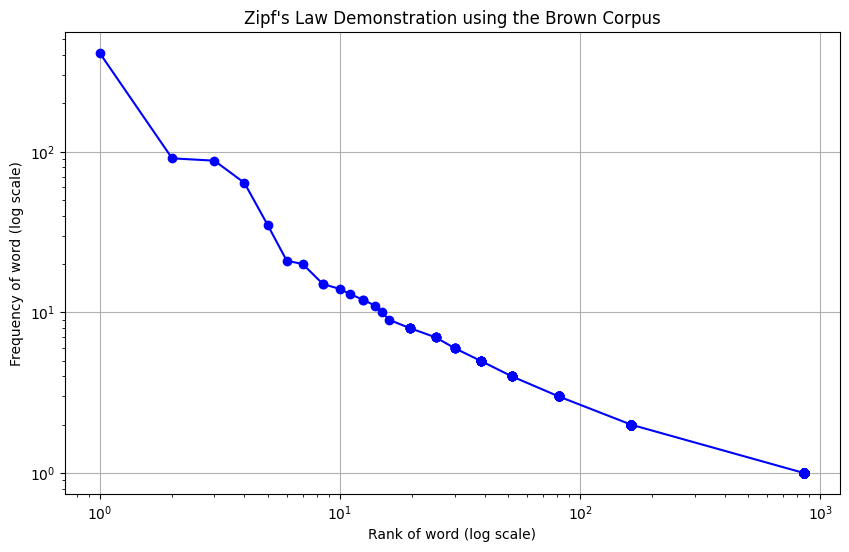

In [65]:
ak_2024_df = extract_author_keywords(wos_2024)
ak_2024_freq_df = pd.DataFrame(Counter([keyword.strip() for sublist in ak_2024_df['Author Keywords'].dropna().str.lower().str.split(', ') for keyword in sublist]).items(), columns=["Keyword", "Frequency"])
ak_2024_freq_df = ak_2024_freq_df.sort_values(by="Frequency", ascending=False)
ak_2024_freq_df['Rank'] = ak_2024_freq_df['Frequency'].rank(ascending=False)

# Plotting Zipfs law

plt.figure(figsize=(10, 6))
plt.loglog(ak_2024_freq_df['Rank'], ak_2024_freq_df['Frequency'], marker='o', linestyle='-', color='b')
plt.title('Zipf\'s Law Demonstration using the Brown Corpus')
plt.xlabel('Rank of word (log scale)')
plt.ylabel('Frequency of word (log scale)')
plt.grid(True)
plt.show()


In [66]:
"""
Zipf Law's Analysis

f(r) = C / r^s

where
f(r) = frequency of the word at rank
r = rank of the word (1 for most frequent, 2 for second most frequent, etc.)
C = normalization constant (depends on the dataset)
s = exponent (usually close to 1 for natural languages)

Results:
Positive deviation → keyword is more frequent than Zipf’s Law expected values → possible emerging topic.
Negative deviation → less frequent than expected.

"""
top_freq = ak_2024_freq_df["Frequency"].iloc[0]
ak_2024_freq_df["Expected_Frequency"] = top_freq / ak_2024_freq_df["Rank"]
ak_2024_freq_df["Deviation"] = ak_2024_freq_df["Frequency"] - ak_2024_freq_df["Expected_Frequency"]
df_sorted_by_deviation = ak_2024_freq_df.sort_values(by="Deviation", ascending=False)

df_sorted_by_deviation

Keyword  Frequency   Rank  Expected_Frequency  \
595                   consumer behavior          1  858.0            0.479021   
585               deep generative model          1  858.0            0.479021   
603                              racism          1  858.0            0.479021   
604                    student advising          1  858.0            0.479021   
605                              cyborg          1  858.0            0.479021   
..                                  ...        ...    ...                 ...   
5                  large language model         64    4.0          102.750000   
236  generative artificial intelligence         35    5.0           82.200000   
21                     higher education         21    6.0           68.500000   
101                             chatgpt         88    3.0          137.000000   
8               artificial intelligence         91    2.0          205.500000   

      Deviation  
595    0.520979  
585    0.520979  
603    0.520979  
604    0.520979  
605    0.520979  
..          ...  
5    -38.750000  
236  -47.200000  
21   -47.500000  
101  -49.000000  
8   -114.500000  

[1492 rows x 5 columns]

<b>Analysis:</b> <br>
Based on the above analysis, we observe that keywords with a frequency of 1 have a deviation of around 0.5, suggesting that these keywords may be emerging topics for future research.


<b> Avg Weight vs End Point Degree </b>

In [67]:
# Weight of Keyword pairs

G = nx.Graph()

for keyword_list in auth_keyword_2024_list:
    for kw1, kw2 in itertools.combinations(set(keyword_list), 2):
        if G.has_edge(kw1, kw2):
            G[kw1][kw2]['weight'] += 1
        else:
            G.add_edge(kw1, kw2, weight=1)

edges_data = [(u, v, d['weight']) for u, v, d in G.edges(data=True)]
edges_df = pd.DataFrame(edges_data, columns=['Source', 'Target', 'Weight'])
edges_df_sorted = edges_df.sort_values(by='Weight', ascending=False)

edges_df_sorted


Source                   Target  Weight
3                         generative ai  artificial intelligence      75
20                        generative ai                  chatgpt      75
1                         generative ai     large language model      55
67              artificial intelligence                  chatgpt      20
11                        generative ai                education      19
..                                  ...                      ...     ...
206                      explainable ai          user experience       1
208  generative artificial intelligence               assessment       1
209  generative artificial intelligence                    genai       1
210                               genai               assessment       1
212                          assessment                 pedagogy       1

[213 rows x 3 columns]

In [68]:
# Calculate degree and strength for each node
node_stats = []

for node in G.nodes():
    degree = G.degree(node)
    strength = G.degree(node, weight='weight')
    node_stats.append({"Node": node, "Degree": degree, "Strength": strength})

node_stats_df = pd.DataFrame(node_stats)
node_stats_df_sorted = node_stats_df.sort_values(by="Strength", ascending=False)
node_stats_df_sorted.head(10)


Node  Degree  Strength
0                        generative ai      31       433
4              artificial intelligence      30       201
21                             chatgpt      25       170
2                 large language model      26       144
12                           education      18        67
6                     higher education      19        65
25  generative artificial intelligence      20        46
17                                 llm      18        42
13                             chatbot      19        40
10                               ethic      16        40

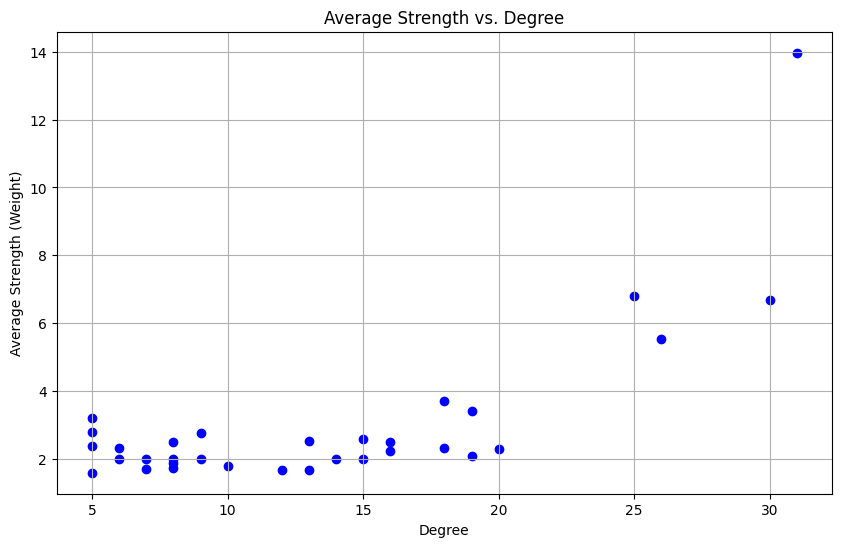

In [69]:
# Calculate average strength for each node
average_strength = {node: 0 for node in G.nodes()}
for node in G.nodes():
    total_weight = sum([attr['weight'] for _, _, attr in G.edges(node, data=True)])
    average_strength[node] = total_weight / G.degree(node)

# Extract degree and average strength for each node
degrees = [G.degree(node) for node in G.nodes()]
average_strengths = [average_strength[node] for node in G.nodes()]

plt.figure(figsize=(10, 6))
plt.scatter(degrees, average_strengths, color='blue')
plt.title("Average Strength vs. Degree")
plt.xlabel("Degree")
plt.ylabel("Average Strength (Weight)")
plt.grid(True)
plt.show()

<b> Analysis </b> <br>

a) 'generative ai' is high degree and high average strength indicating that they are high impact keywords and are likely to be trending topics that are used for future research terms.
<br>
b) 'artificial intelligence', 'chatgpt' and 'large language model' are having high degree and moderate average strength indicating that occurs many times and connections are relatively weak.

<b> Final Analysis </b>
<br>
Based on the analysis above for the year 2024, we can see that the focus areas of current research is revolving around these topics - <b> generative ai , artificial intelligence, chatgpt and large language model</b> . It is likely that future research will continue to evolve around these core areas indicating development in these domains.